In [63]:
import pyhf
import json
import matplotlib.pyplot as plt
from scipy.stats import chi2, norm
import matplotlib
import numpy as np
import uproot
from matplotlib import cm
from iminuit import Minuit
matplotlib.rcParams['figure.facecolor'] = 'white'

# Beeston-Barlow (BB) lite function

## Beeston-Barlow

The complete BB likelihood for a single bin assumes Poisson distributed data and Poisson distributed MC production of the template. The total likelihood is:
$$
\begin{align}
    \log{\mathcal{L}_{i}} &= \log{\mathcal{L}_{data, i}} + \log{\mathcal{L}_{nuisance, i}}\\
        &= D_i\log{f_i} - f_i - \log{D_i!} \\
        &+ \sum_j a_{i,j}\log{A_{i,j}} - A_{i,j} - \log{a_{i,j}!}\\
    f_i &= \sum_j p_j A_{i,j} \\
    p_j &= \frac{\hat{\mathcal{N}}_j}{\mathcal{N}_{MC, j}}
\end{align}
$$
with $i$ the index running on all bins and $j$ running on the populations.
This introduces one nuisance parameter per bin per population. This can be reduced to one non-linear equation per bin (see [Beeston-Barlow](https://doi.org/10.1016/0010-4655(93)90005-W)).  


It has been observed that the finite precision of computers can introduce discrete jumps in the likelihood. Additionally, whenever using interpolation techniques between histograms such as template morphing, every histogram must be included in the likelihood, and in case of more sofisticated morphing techniques, the equations for the $A_{i,j}$s don't decouple anymore, making the search of the maximium of the likelihood expensive or impossible.

## Conway approximation
Conway (see [Conway](https://indico.cern.ch/event/107747/contributions/32677/attachments/24368/35057/conway.pdf)) argues that, eventually, only the total statistical uncertainty on $f_i$ is relevant and introduces a multiplying factor per bin with expected value 1 and distributed with a gaussian of with equal to the relative statistical uncertainty on the bin estimate:
$$
\begin{align}
    \log{\mathcal{L}_{nuisance, i}} &= \frac{(\beta_i - 1)^2}{2 V_{\beta_i}}\\
    f_i &= \beta_i \sum_j p_j a_{i,j} \\
    V_{\beta_i} &= \frac{\sum_j p_j^2 a_{i,j}}{(\sum_j p_j a_{i,j})^2}
\end{align}
$$

For a given set of the other parameters, the $\beta_i$ are univoquelly determined with a 2nd order equation:
$$
\beta_i^2 + (f_i V_{\beta_i} - 1)\beta_i - D_iV_{\beta_i} = 0
$$

## Dembinski-Abdelmotteleb approximation

This is a good approximation in case each sample has a high enough statistics so that the Poisson nuisances can be approximated by a normal distribution. An alternative approach ([Dembinski-Abdelmotteleb](https://doi.org/10.1140/epjc/s10052-022-11019-z)) is to use an effective Poisson instead, to model the asymmetry in low statistics scenarios. The effective Poisson will have average $\mu_{i,eff}$:
$$
\mu_{i,eff} = \frac{1}{V_{\beta_i}}
$$

The authors propose a closed analytical expression for $\beta_i$ in such a case:
$$
\begin{align}
    \beta_i &= \frac{D_i + \mu_{i,eff}}{\mu_0 + \mu_{i,eff}}\\
    \mu_0 &= \sum_j p_j a_{i,j}
\end{align}
$$

This still requires that an estimate of the bin size can be made and that in a given bin if $a_{i,j}=0$, that population $j$ should be expected to contribute negligibly to the estimate of bin $i$.

The contribution from parametric PDFs is naturally included by defining $f_i$ as:
$$
    f_i = \beta_i\mu_0 + f(i|\theta)
$$
with $f(i|\theta)$ the binned PDF depending on parameters $\theta$ computed in bin $i$.

In [64]:
def BBliteBeta(Di, mu0, mueff):
    betas = (Di + mueff)/(mu0 + mueff + (mu0 == 0))
    return betas + (betas == 0)

# Python implementation of momentum morphing class algorithm in https://arxiv.org/pdf/1410.7388.pdf
import numpy as np
from scipy.interpolate import RectBivariateSpline
# The class takes as input a numpy array with the first axis being the morphing parameter, the list of m parameters and the reference value of the morphing parameter

class MorphTemplate1D:
    def __init__(self, hist, ms, m0):
        self.hist = hist
        self.originalMS = ms
        self.maxMs = max(ms)
        self.minMs = min(ms)
        self.n = len(self.hist)
        self.ms = ms
        self.m0 = m0
        self.m0Index = self.findm0()
        self.ms = self.ChebyshevNodes(ms)
        self.M = self.computMmatrix()
    
    # Compute Chebyshev nodes
    def ChebyshevNodes(self, ms):
        k = (ms - self.minMs)/(self.maxMs - self.minMs)*(self.n-1) + 1
        res = np.cos((k - 1)*np.pi/(self.n-1))
        return res
    
    # Find the index of m0 in ms
    def findm0(self):
        if self.m0 not in self.ms:
            return 0
        else:
            return np.where(self.ms == self.m0)[0][0]
    
    # Compute the M matrix
    def computMmatrix(self):
        n = len(self.hist)
        
        M = np.ones((n, n))
        M = (M*(self.ms - self.ms[self.m0Index])).transpose()
        M = np.power(M, np.arange(n))
        M = np.linalg.inv(M).transpose()
        return M
    
    # Compute ci coefficients
    def computCi(self, m):
        deltam = np.power(m - self.ms[self.m0Index], np.linspace(0, len(self.hist) - 1, len(self.hist)))
        c = np.dot(self.M, deltam)
        return c

    # Compute the morphed template
    def morphTemplate(self, x, hist=None):
        # Apply Chebyshev nodes
        smear = self.ChebyshevNodes(x)
        ci = self.computCi(smear)
        if hist is not None:
            thist = np.swapaxes(hist, 0, len(hist.shape) - 1)
        else:
            thist = np.swapaxes(self.hist, 0, len(self.hist.shape) - 1)
        res = np.dot(thist, ci).transpose()
        res = res*(res > 0)
        return res

class histHandler:
    def __init__(self, channels, dataName, BKGnames, var1, var2, alphaNames = [], alphavalues = [], alphaRefs = []):
        self.channels = channels
        self.dataName = dataName
        self.BKGnames = BKGnames
        self.alphaNames = alphaNames
        self.alphavalues = alphavalues
        self.alphaRefs = alphaRefs
        self.var1 = var1
        self.var2 = var2
        self.DataArray = []
        self.DataArrayToy = []
        self.BKGarray = []
        self.BKGarrayCumSum = []
        self.BKGarrayNuisance = []
        self.BKGarrayNuisance5Sigma = []
        self.BKGarrayNuisanceCumSum = []
        self.BKGarrayToy = []
        self.BKGarrayNuisance5SigmaToy = []
        self.BKGarrayNuisance5SigmaArrayToy = []
        self.nMCs = []
        self.morphers = []
        self.initializeArrays()
        
    # Prepare histograms
    def initializeArrays(self):
        # Produce 1D hist of data
        hist = []
        for channel in self.channels.keys():
            hist.append(self.channels[channel][self.dataName].flatten())
        self.DataArray = np.concatenate(hist)
        
        # Produce 1D BKG arrays
        hist = []
        nMCs = []
        histCumSum = []
        for i in range(len(self.BKGnames)):
            thist = []
            for channel in self.channels.keys():
                thist.append(self.channels[channel][self.BKGnames[i]].flatten())
            hist.append(np.concatenate(thist))
            histCumSum.append(hist[-1].cumsum())
            nMCs.append(hist[-1].sum())
        self.BKGarray = np.array(hist)
        self.BKGarrayCumSum = np.array(histCumSum)
        self.nMCs = np.array(nMCs)
        
        # Produce 1D histset for shape nuisance parameters
        # The final array has three indeces:
        # - the first one running on the systematics
        # - the second one running on the bins
        # - the third one running between the -1, 0 and +1 sigma variation of the systematic
        hist = []
        histCumSum = []
        if len(self.alphaNames) > 0:
            for a in range(len(self.alphaNames)):
                histSet = []
                histSetCumSum = []
                for b in range(len(self.BKGarray)):
                    thist_dn = []
                    thist_up = []
                    thist = []
                    for channel in self.channels.keys():
                        thist_dn.append(self.channels[channel][self.BKGnames[b]+self.alphaNames[a]+"_dn"].flatten())
                        thist_up.append(self.channels[channel][self.BKGnames[b]+self.alphaNames[a]+"_up"].flatten())
                        thist.append(self.channels[channel][self.BKGnames[b]].flatten())
                    
                    histSet.append(np.array([np.concatenate(thist_dn), np.concatenate(thist), np.concatenate(thist_up)]))
                    histSetCumSum.append(histSet[-1].cumsum(axis=1))
                hist.append(histSet)
                histCumSum.append(histSetCumSum)
            self.BKGarrayNuisance = np.array(hist)
            self.BKGarrayNuisanceCumSum = np.array(histCumSum)
            
        hist = []
        if len(self.alphaNames) > 0:
            for a in range(len(self.alphaNames)):
                histSet = []
                thistSet = []
                for b in range(len(self.BKGarray)):
                    thist_5dn = []
                    thist_4dn = []
                    thist_3dn = []
                    thist_2dn = []
                    thist_dn = []
                    thist_up = []
                    thist_2up = []
                    thist_3up = []
                    thist_4up = []
                    thist_5up = []
                    thist = []
                    for channel in self.channels.keys():
                        thist_5dn.append(self.channels[channel][self.BKGnames[b]+self.alphaNames[a]+"_5dn"].flatten())
                        thist_4dn.append(self.channels[channel][self.BKGnames[b]+self.alphaNames[a]+"_4dn"].flatten())
                        thist_3dn.append(self.channels[channel][self.BKGnames[b]+self.alphaNames[a]+"_3dn"].flatten())
                        thist_2dn.append(self.channels[channel][self.BKGnames[b]+self.alphaNames[a]+"_2dn"].flatten())
                        thist_dn.append(self.channels[channel][self.BKGnames[b]+self.alphaNames[a]+"_1dn"].flatten())
                        thist.append(self.channels[channel][self.BKGnames[b]].flatten())
                        thist_up.append(self.channels[channel][self.BKGnames[b]+self.alphaNames[a]+"_1up"].flatten())
                        thist_2up.append(self.channels[channel][self.BKGnames[b]+self.alphaNames[a]+"_2up"].flatten())
                        thist_3up.append(self.channels[channel][self.BKGnames[b]+self.alphaNames[a]+"_3up"].flatten())
                        thist_4up.append(self.channels[channel][self.BKGnames[b]+self.alphaNames[a]+"_4up"].flatten())
                        thist_5up.append(self.channels[channel][self.BKGnames[b]+self.alphaNames[a]+"_5up"].flatten())
                    
                    # Morphing happens on a ratio so we can stack the effect just by multiplying the factors
                    histSet.append(np.array([np.concatenate(thist_5dn), np.concatenate(thist_4dn), np.concatenate(thist_3dn), np.concatenate(thist_2dn), np.concatenate(thist_dn), np.concatenate(thist), np.concatenate(thist_up), np.concatenate(thist_2up), np.concatenate(thist_3up), np.concatenate(thist_4up), np.concatenate(thist_5up)]))
                    thistSet.append(np.array([np.concatenate(thist_5dn), np.concatenate(thist_4dn), np.concatenate(thist_3dn), np.concatenate(thist_2dn), np.concatenate(thist_dn), np.concatenate(thist), np.concatenate(thist_up), np.concatenate(thist_2up), np.concatenate(thist_3up), np.concatenate(thist_4up), np.concatenate(thist_5up)])/(self.BKGarray[b] + 1*(self.BKGarray[b] == 0)))
                hist.append(histSet)
                if len(self.alphaRefs) > 0 and len(self.alphavalues) > 0:
                    thist = np.swapaxes(thistSet, 1, 2)
                    thist = np.concatenate(thist, axis=0)
                    thist = np.swapaxes(thist, 0, 1)
                    self.morphers.append(MorphTemplate1D(thist, self.alphavalues[a], self.alphaRefs[a]))
                    self.BKGarrayNuisance5SigmaArrayToy.append(thist)
            self.BKGarrayNuisance5Sigma = np.array(hist)
            self.BKGarrayNuisance5SigmaToy = np.array(hist)
            self.BKGarrayNuisance5SigmaArrayToy = np.array(self.BKGarrayNuisance5SigmaArrayToy)
            
    def getEstimateBB(self, yields, Ai):
        temphists = np.copy(Ai)
        totMCs = self.nMCs
        temphists = np.matmul(yields/totMCs, temphists)
        return temphists
    
    def getEstimateBBUncertainty(self, yields, Ai):
        temphists = np.copy(Ai)
        totMCs = self.nMCs
        temphists = np.matmul(np.power(yields/totMCs, 2), temphists)
        return np.sqrt(temphists)
    
    def getEstimateBBVariance(self, yields, Ai):
        temphists = np.copy(Ai)
        totMCs = self.nMCs
        temphists = np.matmul(np.power(yields/totMCs, 2), temphists)
        return temphists
    
    def getMorphedBKGarray(self, morph = []):
        temphists = np.copy(self.BKGarray)
        for i in range(len(morph)):
            morphed = self.morphers[i].morphTemplate(morph[i])
            morphed = np.reshape(morphed, self.BKGarray.shape)
            temphists *= morphed
        return temphists
    
    def getMorphedBKGarrayToy(self, morph = []):
        temphists = np.copy(self.BKGarrayToy)
        for i in range(len(morph)):
            morphed = self.morphers[i].morphTemplate(morph[i], hist = self.BKGarrayNuisance5SigmaArrayToy[i])
            morphed = np.reshape(morphed, self.BKGarray.shape)
            temphists *= morphed
        return temphists
    
    def getEstimate(self, yields, betas = 1, nus=1, morph = []):
        if len(morph) > 0:
            temphists = self.getMorphedBKGarray(morph)
            totMCs = np.sum(temphists, axis=1)
        else:
            temphists = np.copy(self.BKGarray)  # Create a copy of self.BKGarray
            totMCs = self.nMCs
        temphists *= betas*nus
        temphists = np.matmul(yields/totMCs, temphists)
        return temphists
    
    def getEstimateToy(self, yields, betas = 1, nus=1, morph = []):
        if len(morph) > 0:
            temphists = self.getMorphedBKGarrayToy(morph)
        else:
            temphists = np.copy(self.BKGarrayToy)
        totMCs = np.sum(temphists, axis=1)
        temphists *= betas*nus
        temphists = np.matmul(yields/totMCs, temphists)
        return temphists
    
    def getEstimateUncertaintyToy(self, yields, betas = 1, nus=1):
        temp = np.copy(self.BKGarrayToy)
        totMCs = np.sum(temp, axis=1)
        temp *= np.power(betas*nus, 2)
        temp = np.matmul(np.power(yields/totMCs, 2), temp)
        return np.sqrt(temp)
    
    def getEstimateVarianceToy(self, yields, betas = 1, nus=1):
        temp = np.copy(self.BKGarrayToy)
        totMCs = np.sum(temp, axis=1)
        totMCs = self.nMCs
        temp *= np.power(betas*nus, 2)
        temp = np.matmul(np.power(yields/totMCs, 2), temp)
        return temp

    def getEstimateUncertainty(self, yields, betas = 1, nus=1, morph = []):
        if len(morph) > 0:
            temphists = self.getMorphedBKGarray(morph)
            totMCs = np.sum(temphists, axis=1)
        else:
            temphists = np.copy(self.BKGarray)  # Create a copy of self.BKGarray
            totMCs = self.nMCs
        temphists *= np.power(betas*nus, 2)
        temphists = np.matmul(np.power(yields/totMCs, 2), temphists)
        return np.sqrt(temphists)

    def getEstimateVariance(self, yields, betas = 1, nus=1, morph = []):
        if len(morph) > 0:
            temphists = self.getMorphedBKGarray(morph)
            totMCs = np.sum(temphists, axis=1)
        else:
            temphists = np.copy(self.BKGarray)  # Create a copy of self.BKGarray
            totMCs = self.nMCs
        temphists *= np.power(betas*nus, 2)
        temphists = np.matmul(np.power(yields/totMCs, 2), temphists)
        return temphists

    def generateToy(self, yields, betas = 1, nus=1, fluctuateTemplates = False, morph = []):
        if fluctuateTemplates:
            #temphists *= betas*nus
            if len(morph) > 0:
                # Sample all reference templates
                temphists = np.copy(self.BKGarrayNuisance5Sigma)
                self.BKGarrayNuisance5SigmaToy = (np.random.poisson(temphists)).astype(float)
                
                # Get BKGarrayToy, they are redundant
                self.BKGarrayToy = np.copy(self.BKGarrayNuisance5SigmaToy[0, :, int(len(self.BKGarray)/2) + 1, :])
                for i in range(len(morph)):
                    if i != 0:
                        self.BKGarrayNuisance5SigmaToy[i, :, int(len(self.BKGarray)/2) + 1, :] = np.copy(self.BKGarrayToy)
                
                # Scale the BKGarrayNuisance5SigmaToy
                for i in range(len(morph)):
                    temphists = np.copy(self.BKGarrayNuisance5SigmaToy[i])
                    temphists = np.swapaxes(temphists, 1, 2)
                    temphists = np.concatenate(temphists, axis=0)
                    temphists = np.swapaxes(temphists, 0, 1)/(np.concatenate(self.BKGarrayToy, axis=0) + 1*(np.concatenate(self.BKGarrayToy, axis=0) == 0))
                    self.BKGarrayNuisance5SigmaArrayToy[i] = temphists
            else:
                temphists = np.copy(self.BKGarray)
                temphists = (np.random.poisson(temphists)).astype(float)
                self.BKGarrayToy = np.copy(temphists)
        else:
            self.BKGarrayToy = np.copy(self.BKGarray)
        
        #self.DataArrayToy = np.random.poisson(self.getEstimate(yields, betas, nus))
        temphists = self.getEstimateToy(yields, betas, nus, morph)
        temphists = temphists*(1 - (temphists < 0)*(np.abs(temphists) < 1e-3))
        if (temphists < 0).any():
            print("Warning: negative prediction in toy generation")
            print(temphists)
            print("Yields: ", yields)
            print("Betas: ", betas)
        self.DataArrayToy = np.random.poisson(temphists)
        if fluctuateTemplates:
            #temphists *= betas*nus
            if len(morph) > 0:
                # Sample all reference templates
                temphists = np.copy(self.BKGarrayNuisance5Sigma)
                self.BKGarrayNuisance5SigmaToy = (np.random.poisson(temphists)).astype(float)
                
                # Get BKGarrayToy, they are redundant
                self.BKGarrayToy = np.copy(self.BKGarrayNuisance5SigmaToy[0, :, int(len(self.BKGarray)/2) + 1, :])
                for i in range(len(morph)):
                    if i != 0:
                        self.BKGarrayNuisance5SigmaToy[i, :, int(len(self.BKGarray)/2) + 1, :] = np.copy(self.BKGarrayToy)
                
                # Scale the BKGarrayNuisance5SigmaToy
                for i in range(len(morph)):
                    temphists = np.copy(self.BKGarrayNuisance5SigmaToy[i])
                    temphists = np.swapaxes(temphists, 1, 2)
                    temphists = np.concatenate(temphists, axis=0)
                    temphists = np.swapaxes(temphists, 0, 1)/(np.concatenate(self.BKGarrayToy, axis=0) + 1*(np.concatenate(self.BKGarrayToy, axis=0) == 0))
                    self.BKGarrayNuisance5SigmaArrayToy[i] = np.copy(temphists)
            else:
                temphists = np.copy(self.BKGarray)
                temphists = (np.random.poisson(temphists)).astype(float)
                self.BKGarrayToy = np.copy(temphists)
        else:
            self.BKGarrayToy = np.copy(self.BKGarray)


# Likelihood definition
In [Baker-Cowsins](https://doi.org/10.1016/0167-5087(84)90016-4) it is shown that for a Poisson distributed bins, the likelihood can be written in a form that is asymptotically behaving as a $\chi^2$:
$$
\begin{align}
    \lambda_i &= -2 \log{\frac{\mathcal{L}(D_i|f_i)}{\mathcal{L}(D_i|D_i)}}\\
        &= -2(D_i\log{f_i} - f_i - D_i\log{D_i} + D_i)
\end{align}
$$
where $D_i$ is the counts in the data bin $i$ and $f_i$ is the predicted counts in the bin $i$. This allows to remove the factorial term and can be used for a full FC construction as the term $\mathcal{L}(D_i|D_i)$ cancels out.

This formalism can be extended to any term in the likelihood by dividing by their value at the nominal. For the BB-lite likelihood means subtracting the $\log{\mathcal{L}}$ computed in $\beta_i=1$.
The total likelihood of the single bin  becomes:
$$
\begin{align}
    \lambda_i &= -2 \log{\frac{\mathcal{L}(D_i|f_i)}{\mathcal{L}(D_i|D_i)}}\\
        &= -2[D_i\log{f_i} - f_i - D_i\log{D_i} + D_i \\
        &+ \mu_{i,eff}(\log{\beta_i\mu_{i,eff}} - \beta_i) - \mu_{i,eff}(\log{\mu_{i,eff}} - 1)]
\end{align}
$$

The total likelihood will then include any additional contribution from systematic parameters ($\alpha_k$) and penalty terms ($P$) to set additional constraint:
$$
\begin{align}
    \lambda = \sum_i \lambda_i + \sum_k \alpha_k^2 + P
\end{align}
$$
with $\alpha_k$ parametrized so that the expected value is 0 and the standard deviation is 1.

In [65]:
def likelihood(Di, fPar, mu, mueff, betas, alphas, P = 0):
    f = mu + fPar
    binnedTerm = Di*np.log(f + (f == 0)) - f - Di*np.log(Di + (Di == 0)) + Di
    binnedTerm = binnedTerm + mueff*(np.log(betas) - (betas - 1))
    binnedTerm = -2*np.sum(binnedTerm)
    return binnedTerm + np.sum(np.power(alphas, 2)) + P

def likelihoodBB(Di, fPar, mu, ai, Ai, alphas, P = 0):
    f = mu + fPar
    binnedTerm = Di*np.log(f + (f == 0)) - f - Di*np.log(Di + (Di == 0)) + Di
    binnedTerm += np.sum(ai*np.log(Ai) - Ai - ai*np.log(ai) + ai)
    binnedTerm = -2*np.sum(binnedTerm)
    return binnedTerm + np.sum(np.power(alphas, 2)) + P

# Data preparation
## Channel declaration and globals

In [66]:
channels = {
    'ch1': {
        'name': 'X17 2023, low angle',
        'Esum': [15, 20, 100], # [min, max, nBins]
        'Angle': [0, 180, 1]
    },
    #'ch2': {
    #    'name': 'X17 2023, low energy, high angle',
    #    'Esum': [15, 16, 1],
    #    'Angle': [80, 180, 5]
    #},
    #'ch3': {
    #    'name': 'X17 2023, high energy, high angle',
    #    'Esum': [16, 20, 2],
    #    'Angle': [80, 180, 10]
    #},
    #'ch4': {
    #    'name': 'X17 2023, low angle',
    #    'Esum': [15, 16, 2], # [min, max, nBins]
    #    'Angle': [0, 80, 16]
    #},
}
massElectron = 0.5109989461 #MeV
alphares = 0.01
alphafield = 0.01 #0.003

esumCutLow = 16
esumCutHigh = 20
angleCutLow = 115
angleCutHigh = 160

workDir = './results/'
dataFile = 'data2023.root'
MCFile = 'MC2023tot.root'


## Useful functions

In [67]:
matplotlib.rcParams.update({'font.size': 30})
def plotChannels(channels, sample='dataHist', title='Data'):
    matplotlib.rcParams.update({'font.size': 30})
    hists = []
    maxBin = 0
    minEsum = 100
    maxEsum = 0
    minAngle = 180
    maxAngle = 0
    # check if sample is a 
    if type(sample) == list:
        fig = plt.figure(figsize=(14*len(sample)*1.1, 14), dpi=100)
        plt.suptitle(title)
        numberOfSubPlots = len(sample)
        for s in sample:
            hists = []
            plt.subplot(1, numberOfSubPlots, sample.index(s)+1)
            plt.title(s)
            for channel in channels.keys():
                hist = channels[channel][s]/(channels[channel]['Esum'][1] - channels[channel]['Esum'][0])*channels[channel]['Esum'][2]
                maxBin = max(maxBin, np.max(hist))
                minEsum = min(minEsum, channels[channel]['Esum'][0])
                maxEsum = max(maxEsum, channels[channel]['Esum'][1])
                minAngle = min(minAngle, channels[channel]['Angle'][0])
                maxAngle = max(maxAngle, channels[channel]['Angle'][1])
                hists.append(hist)
            
            for channel, hist in zip(channels.keys(), hists):
                plt.imshow(hist, cmap='coolwarm', extent=[channels[channel]['Angle'][0], channels[channel]['Angle'][1], channels[channel]['Esum'][0], channels[channel]['Esum'][1]], aspect='auto', interpolation='none', norm=matplotlib.colors.LogNorm(vmin=1, vmax=maxBin), origin='lower')
                plt.xlabel(r'$\theta_{\mathrm{rel}}$ [deg]')
                plt.ylabel(r'$E_{\mathrm{sum}}$ [MeV]')
                # Draw bin borders as well
                for line in np.linspace(channels[channel]['Esum'][0], channels[channel]['Esum'][1], channels[channel]['Esum'][2]+1):
                    plt.hlines(line, channels[channel]['Angle'][0], channels[channel]['Angle'][1], colors='k', linestyles='dashed')
                for line in np.linspace(channels[channel]['Angle'][0], channels[channel]['Angle'][1], channels[channel]['Angle'][2]+1):
                    plt.vlines(line, channels[channel]['Esum'][0], channels[channel]['Esum'][1], colors='k', linestyles='dashed')
                plt.grid()
            plt.xlim(minAngle, maxAngle)
            plt.ylim(minEsum, maxEsum)
            cbar = plt.colorbar()
            cbar.set_label(r'Counts/MeV/deg')
        plt.show()
    else: 
        fig = plt.figure(figsize=(28, 14), dpi=100)
        plt.title(title)
        for channel in channels.keys():
            hist = channels[channel][sample]/(channels[channel]['Esum'][1] - channels[channel]['Esum'][0])*channels[channel]['Esum'][2]
            maxBin = max(maxBin, np.max(hist))
            minEsum = min(minEsum, channels[channel]['Esum'][0])
            maxEsum = max(maxEsum, channels[channel]['Esum'][1])
            minAngle = min(minAngle, channels[channel]['Angle'][0])
            maxAngle = max(maxAngle, channels[channel]['Angle'][1])
            hists.append(hist)

        for channel, hist in zip(channels.keys(), hists):
            plt.imshow(hist, cmap='coolwarm', extent=[channels[channel]['Angle'][0], channels[channel]['Angle'][1], channels[channel]['Esum'][0], channels[channel]['Esum'][1]], aspect='auto', interpolation='none', norm=matplotlib.colors.LogNorm(vmin=1, vmax=maxBin), origin='lower')
            plt.xlabel(r'$\theta_{\mathrm{rel}}$ [deg]')
            plt.ylabel(r'$E_{\mathrm{sum}}$ [MeV]')
            # Draw bin borders as well
            for line in np.linspace(channels[channel]['Esum'][0], channels[channel]['Esum'][1], channels[channel]['Esum'][2]+1):
                plt.hlines(line, channels[channel]['Angle'][0], channels[channel]['Angle'][1], colors='k', linestyles='dashed')
            for line in np.linspace(channels[channel]['Angle'][0], channels[channel]['Angle'][1], channels[channel]['Angle'][2]+1):
                plt.vlines(line, channels[channel]['Esum'][0], channels[channel]['Esum'][1], colors='k', linestyles='dashed')
            #plt.grid()
        plt.xlim(minAngle, maxAngle)
        plt.ylim(minEsum, maxEsum)
        cbar = plt.colorbar()
        cbar.set_label(r'Counts/MeV/deg')
        plt.show()

# Create up/down  variables for field and resolution scaling
def createUpDownVariables(p, simp, alphares, alphafield):
    pres_up = (p - simp)*(1 + alphares) + simp
    pres_dn = (p - simp)*(1 - alphares) + simp
    esumres_up = np.sqrt(np.sum(np.power(pres_up[:3], 2), axis=0) + np.power(massElectron, 2)) # positrons
    esumres_up = esumres_up + np.sqrt(np.sum(np.power(pres_up[3:6], 2), axis=0) + np.power(massElectron, 2)) # electrons
    angleres_up = np.arccos(np.sum(pres_up[:3]*pres_up[3:6], axis=0)/np.sqrt(np.sum(np.power(pres_up[:3], 2), axis=0))/np.sqrt(np.sum(np.power(pres_up[3:6], 2), axis=0)))*180/np.pi
    
    esumres_dn = np.sqrt(np.sum(np.power(pres_dn[:3], 2), axis=0) + np.power(massElectron, 2)) # positrons
    esumres_dn = esumres_dn + np.sqrt(np.sum(np.power(pres_dn[3:6], 2), axis=0) + np.power(massElectron, 2)) # electrons
    angleres_dn = np.arccos(np.sum(pres_dn[:3]*pres_dn[3:6], axis=0)/np.sqrt(np.sum(np.power(pres_dn[:3], 2), axis=0))/np.sqrt(np.sum(np.power(pres_dn[3:6], 2), axis=0)))*180/np.pi
    
    pfield_up = p*(1 + alphafield)
    pfield_dn = p*(1 - alphafield)
    esumfield_up = np.sqrt(np.sum(np.power(pfield_up[:3], 2), axis=0) + np.power(massElectron, 2)) # positrons
    esumfield_up = esumfield_up + np.sqrt(np.sum(np.power(pfield_up[3:6], 2), axis=0) + np.power(massElectron, 2)) # electrons
    anglefield_up = np.arccos(np.sum(pfield_up[:3]*pfield_up[3:6], axis=0)/np.sqrt(np.sum(np.power(pfield_up[:3], 2), axis=0))/np.sqrt(np.sum(np.power(pfield_up[3:6], 2), axis=0)))*180/np.pi
    esumfield_dn = np.sqrt(np.sum(np.power(pfield_dn[:3], 2), axis=0) + np.power(massElectron, 2)) # positrons
    esumfield_dn = esumfield_dn + np.sqrt(np.sum(np.power(pfield_dn[3:6], 2), axis=0) + np.power(massElectron, 2)) # electrons
    anglefield_dn = np.arccos(np.sum(pfield_dn[:3]*pfield_dn[3:6], axis=0)/np.sqrt(np.sum(np.power(pfield_dn[:3], 2), axis=0))/np.sqrt(np.sum(np.power(pfield_dn[3:6], 2), axis=0)))*180/np.pi
    
    # Apply cuts
    selectionres_up = (esumres_up < esumCutLow) | (esumres_up > esumCutHigh) | (angleres_up < angleCutLow) | (angleres_up > angleCutHigh)
    selectionres_dn = (esumres_dn < esumCutLow) | (esumres_dn > esumCutHigh) | (angleres_dn < angleCutLow) | (angleres_dn > angleCutHigh)
    selectionfield_up = (esumfield_up < esumCutLow) | (esumfield_up > esumCutHigh) | (anglefield_up < angleCutLow) | (anglefield_up > angleCutHigh)
    selectionfield_dn = (esumfield_dn < esumCutLow) | (esumfield_dn > esumCutHigh) | (anglefield_dn < angleCutLow) | (anglefield_dn > angleCutHigh)
    
    return esumres_up[selectionres_up], angleres_up[selectionres_up], esumres_dn[selectionres_dn], angleres_dn[selectionres_dn], esumfield_up[selectionfield_up], anglefield_up[selectionfield_up], esumfield_dn[selectionfield_dn], anglefield_dn[selectionfield_dn]

def combinedBins(channels, sample='dataHist'):
    bins = []
    for channel in channels.keys():
        bin = np.linspace(channels[channel]['Angle'][0], channels[channel]['Angle'][1], channels[channel]['Angle'][2]+1)
        for i in range(channels[channel]['Esum'][2]):
            bins.append(np.diff(bin))
    return np.concatenate(bins)



## Load data

Channel definition and optimized binning. The channels are defined as different cuts:
* Channel 1: "low relative angle". Here a finer binning is used as this is more sensitive to the resolutions and shape systematics below 100 deg. 0.5 MeV and 5 deg binning is used.
* Channel 2: "high relative angle, low energy". For higher relative angles the MC events are not enough to provide an estimate of the data with a fine binning. One nergy bin only is used between 15 and 16 MeV.
* Channel 3: "high relative angle, high energy". For higher relative angles the MC events are not enough to provide an estimate of the data with a fine binning. One energy bin only is used between 16 and 20 MeV.

<>:11: SyntaxWarning: invalid escape sequence '\g'
<>:11: SyntaxWarning: invalid escape sequence '\g'
/var/folders/tt/yr5h_pkx6pj1f0zdwb_lgyp40000gn/T/ipykernel_923/2569920332.py:11: SyntaxWarning: invalid escape sequence '\g'
  '''


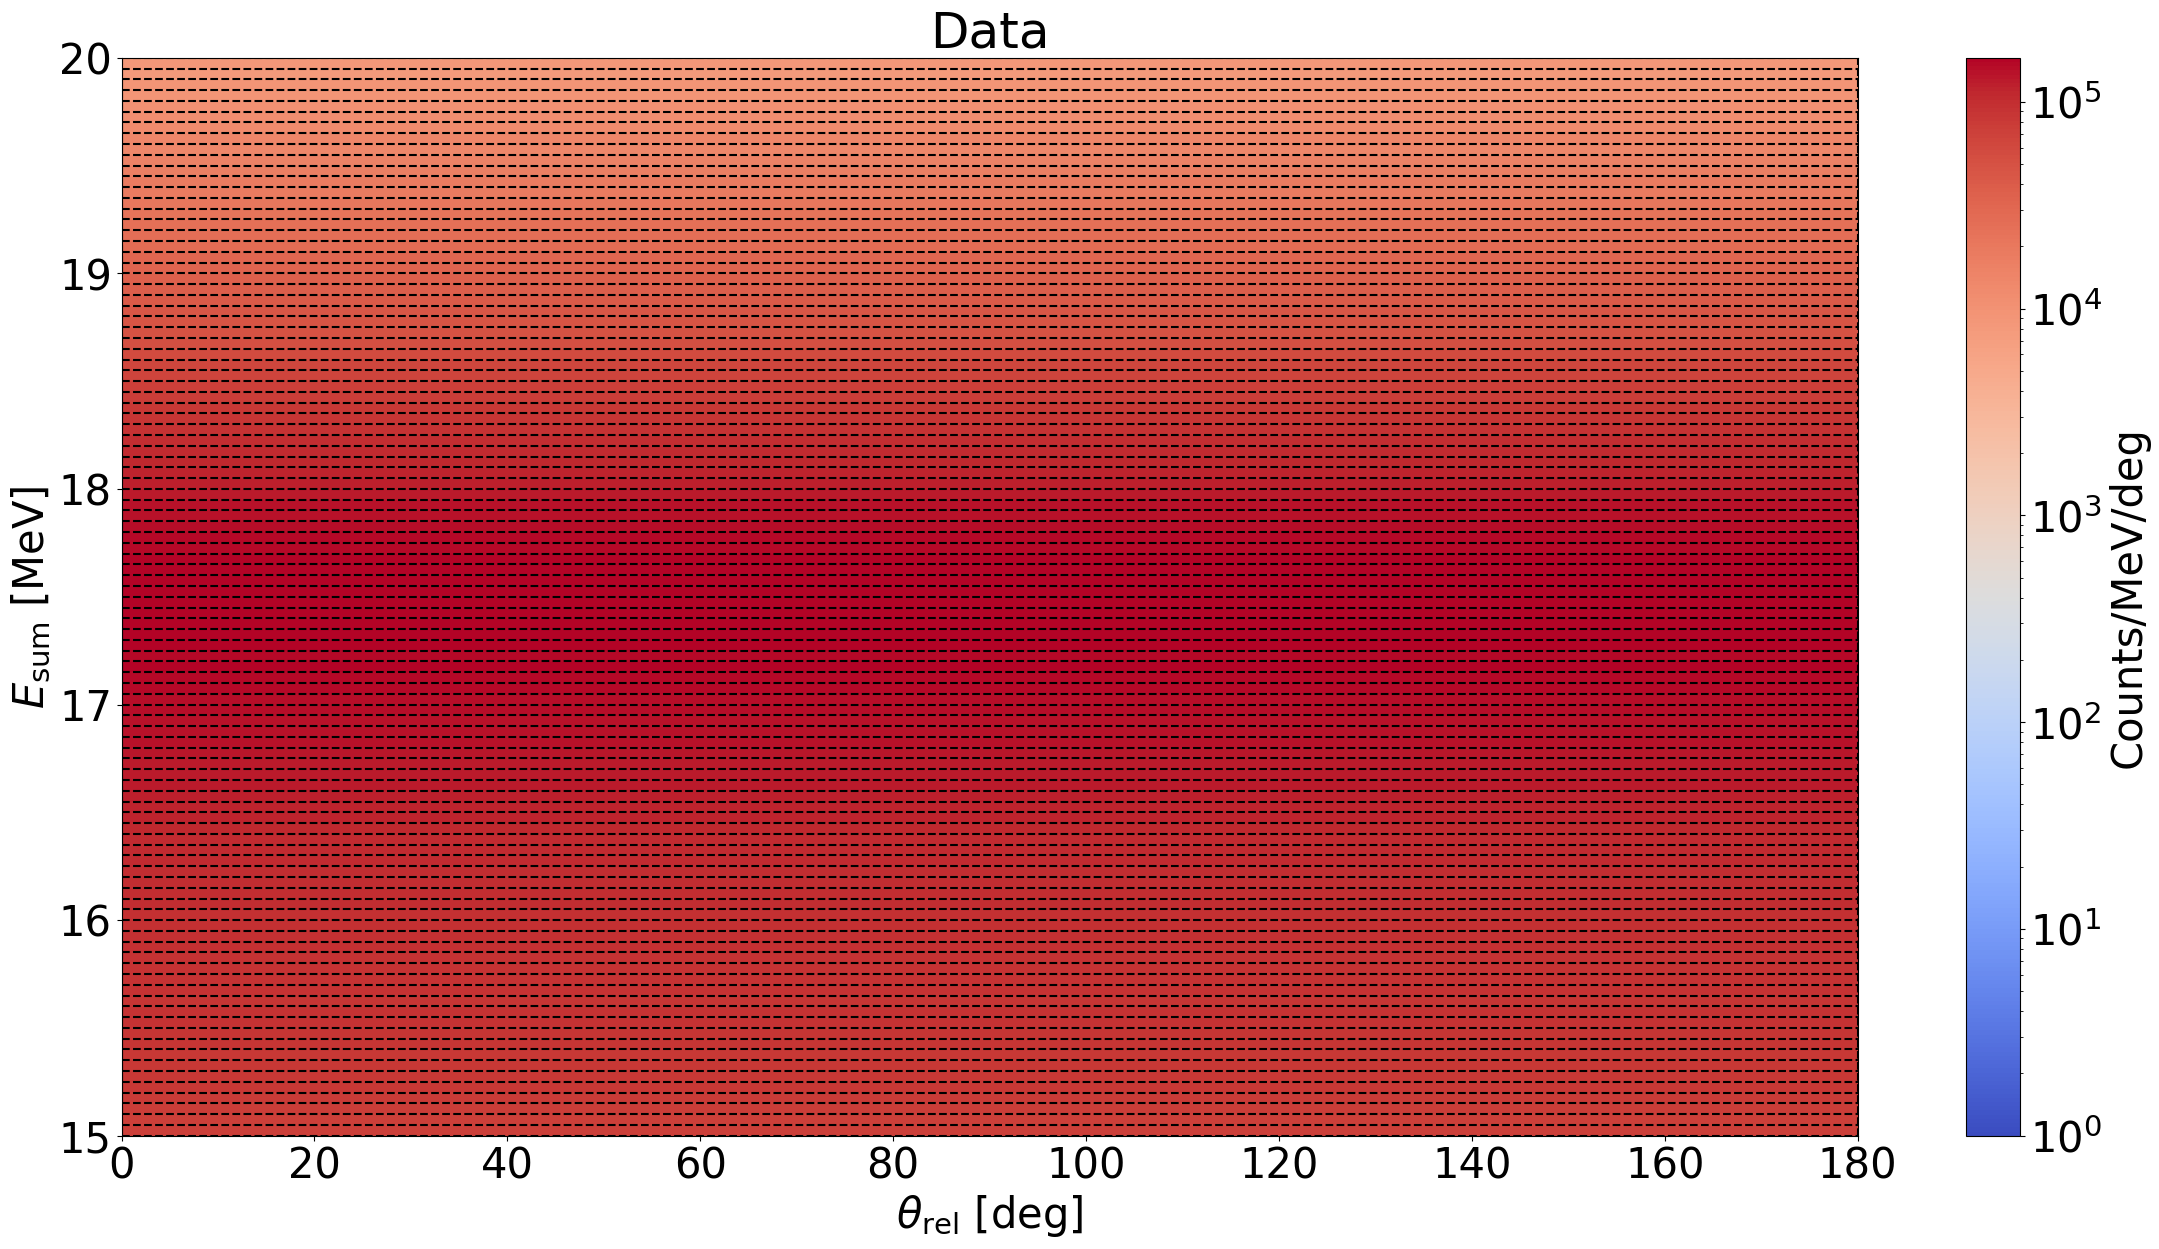

"\n#theta_gamma = theta_gamma[((esum > 15) * (esum < 16)) + ((esum > 16) * (esum < 20) * (angle > 20) * (angle < 180))]\nprint(len(theta_gamma))\nfig = plt.figure(figsize=(28, 14), dpi=100)\nplt.suptitle('Data')\nplt.subplot(121)\nplt.hist(theta_gamma, bins=90, range=(0, 180), histtype='step', color='C0', linewidth=5)\nplt.hist(theta_gamma[theta_gamma <= 80], bins=90, range=(0, 180), color='C1', linewidth=5, alpha=0.5)\nplt.hist(theta_gamma[theta_gamma >= 100], bins=90, range=(0, 180), color='C2', linewidth=5, alpha=0.5)\nplt.xlabel(r'$\theta_{\\gamma}$ [deg]')\nplt.ylabel('Counts')\nplt.xlim(0, 180)\nymax = plt.gca().get_ylim()[1]\nplt.vlines(80, 0, ymax, colors='k', linestyles='dashed', linewidth=5)\nplt.vlines(100, 0, ymax, colors='k', linestyles='dashed', linewidth=5)\nplt.ylim(0, ymax)\nplt.text(30, 0.2*ymax, 'DS', fontsize=70, color='C1', alpha = 0.5)\nplt.text(120, 0.6*ymax, 'US', fontsize=70, color='C2', alpha = 0.5)\nplt.grid()\n\nplt.subplot(122)\nplt.hist(angle, bins=90, ran

In [68]:

with uproot.open(workDir + dataFile + ':ntuple') as f:
    esum = f.arrays(['esum'], 'theta_gamma >= 0', library='np')['esum']*1e3#*0.1531/0.1520
    angle = f.arrays(['angle'], 'theta_gamma >= 0', library='np')['angle']
    theta_gamma = f.arrays(['theta_gamma'], library='np')['theta_gamma']
    for channel in channels.keys():
        dataHist = np.histogram2d(esum, angle, bins=[channels[channel]['Esum'][2], channels[channel]['Angle'][2]], range=[channels[channel]['Esum'][:2], channels[channel]['Angle'][:2]])
        channels[channel]['dataHist'] = dataHist[0]
        channels[channel]['dataHistErr'] = np.sqrt(dataHist[0])

plotChannels(channels)
'''
#theta_gamma = theta_gamma[((esum > 15) * (esum < 16)) + ((esum > 16) * (esum < 20) * (angle > 20) * (angle < 180))]
print(len(theta_gamma))
fig = plt.figure(figsize=(28, 14), dpi=100)
plt.suptitle('Data')
plt.subplot(121)
plt.hist(theta_gamma, bins=90, range=(0, 180), histtype='step', color='C0', linewidth=5)
plt.hist(theta_gamma[theta_gamma <= 80], bins=90, range=(0, 180), color='C1', linewidth=5, alpha=0.5)
plt.hist(theta_gamma[theta_gamma >= 100], bins=90, range=(0, 180), color='C2', linewidth=5, alpha=0.5)
plt.xlabel(r'$\theta_{\gamma}$ [deg]')
plt.ylabel('Counts')
plt.xlim(0, 180)
ymax = plt.gca().get_ylim()[1]
plt.vlines(80, 0, ymax, colors='k', linestyles='dashed', linewidth=5)
plt.vlines(100, 0, ymax, colors='k', linestyles='dashed', linewidth=5)
plt.ylim(0, ymax)
plt.text(30, 0.2*ymax, 'DS', fontsize=70, color='C1', alpha = 0.5)
plt.text(120, 0.6*ymax, 'US', fontsize=70, color='C2', alpha = 0.5)
plt.grid()

plt.subplot(122)
plt.hist(angle, bins=90, range=(0, 180), histtype='step', color='C0', linewidth=5, label='All data')
plt.hist(angle[theta_gamma >= 100], bins=90, range=(0, 180), color='C2', linewidth=5, alpha=0.5, label='US')
plt.hist(angle[theta_gamma <= 80], bins=90, range=(0, 180), color='white', linewidth=5)
plt.hist(angle[theta_gamma <= 80], bins=90, range=(0, 180), color='C1', linewidth=5, alpha=0.5, label='DS')
plt.xlim(0, 180)
plt.xlabel(r'$\theta_{\mathrm{rel}}$ [deg]')
plt.ylabel('Counts')
plt.legend()
plt.grid()
plt.show()
'''

## Load the Monte Carlo templates
The different background populations aer identified through the ecode branch as follows:
* ecode = 1: IPC 17.6 MeV
* ecode = 2: IPC 17.9 MeV
* ecode = 3: IPC 18.1 MeV
* ecode = 4: IPC 14.6 MeV
* ecode = 5: IPC 14.9 MeV
* ecode = 6: IPC 15.1 MeV
* ecode = 7: EPC 18 MeV
* ecode = 8: EPC 15 MeV

In [69]:
BKGnames = ['IPC 17.6', 'IPC 17.9', 'IPC 18.1', 'IPC 14.6', 'IPC 14.9', 'IPC 15.1', 'EPC 18', 'EPC 15']
alphaNames = ['res', 'field']


with uproot.open(workDir + MCFile + ':ntuple') as f:
    MC = f.arrays(['esum', 'angle', 'ecode', 'px_pos', 'py_pos', 'pz_pos', 'px_ele', 'py_ele', 'pz_ele', 'simpx_pos', 'simpy_pos', 'simpz_pos', 'simpx_ele', 'simpy_ele', 'simpz_ele'], 'theta_gamma >= 0', library='np')
    
    for i in range(1, 9): # running on ecode
        esum = MC['esum'][MC['ecode'] == i]*1e3#*0.1531/0.1520
        angle = MC['angle'][MC['ecode'] == i]
        selection = (esum < esumCutLow) | (esum > esumCutHigh) | (angle < angleCutLow) | (angle > angleCutHigh)
        esum = esum[selection]
        angle = angle[selection]
        p = np.vstack((MC['px_pos'][MC['ecode'] == i], MC['py_pos'][MC['ecode'] == i], MC['pz_pos'][MC['ecode'] == i], MC['px_ele'][MC['ecode'] == i], MC['py_ele'][MC['ecode'] == i], MC['pz_ele'][MC['ecode'] == i]))*1e3
        simp = np.vstack((MC['simpx_pos'][MC['ecode'] == i], MC['simpy_pos'][MC['ecode'] == i], MC['simpz_pos'][MC['ecode'] == i], MC['simpx_ele'][MC['ecode'] == i], MC['simpy_ele'][MC['ecode'] == i], MC['simpz_ele'][MC['ecode'] == i]))*1e3
        
        #if i == 8:
        #    esum = esum[:1861]
        #    angle = angle[:1861]
        #    p = p[:, :1861]
        #    simp = simp[:, :1861]
        #elif i == 7:
        #    esum = esum[:6585]
        #    angle = angle[:6585]
        #    p = p[:, :6585]
        #    simp = simp[:, :6585]
            
        
        esumres_up, angleres_up, esumres_dn, angleres_dn, esumfield_up, anglefield_up, esumfield_dn, anglefield_dn = createUpDownVariables(p, simp, alphares, alphafield)
        
        factor = 1
        #if i == 8:
        #    factor = 2
        #elif i == 7:
        #    factor = 2
        #elif i != 0:
        #    factor = 3
        for channel in channels.keys():
            hist = np.histogram2d(esum, angle, bins=[channels[channel]['Esum'][2], channels[channel]['Angle'][2]], range=[channels[channel]['Esum'][:2], channels[channel]['Angle'][:2]])[0]*factor
            histres_up = np.histogram2d(esumres_up, angleres_up, bins=[channels[channel]['Esum'][2], channels[channel]['Angle'][2]], range=[channels[channel]['Esum'][:2], channels[channel]['Angle'][:2]])[0]*factor
            histres_dn = np.histogram2d(esumres_dn, angleres_dn, bins=[channels[channel]['Esum'][2], channels[channel]['Angle'][2]], range=[channels[channel]['Esum'][:2], channels[channel]['Angle'][:2]])[0]*factor
            histfield_up = np.histogram2d(esumfield_up, anglefield_up, bins=[channels[channel]['Esum'][2], channels[channel]['Angle'][2]], range=[channels[channel]['Esum'][:2], channels[channel]['Angle'][:2]])[0]*factor
            histfield_dn = np.histogram2d(esumfield_dn, anglefield_dn, bins=[channels[channel]['Esum'][2], channels[channel]['Angle'][2]], range=[channels[channel]['Esum'][:2], channels[channel]['Angle'][:2]])[0]*factor
            
            channels[channel][BKGnames[i-1]] = hist
            channels[channel][BKGnames[i-1] + 'res_up'] = histres_up
            channels[channel][BKGnames[i-1] + 'res_dn'] = histres_dn
            channels[channel][BKGnames[i-1] + 'field_up'] = histfield_up
            channels[channel][BKGnames[i-1] + 'field_dn'] = histfield_dn
            
            for j in range(1, 6):
                esumres_up, angleres_up, esumres_dn, angleres_dn, esumfield_up, anglefield_up, esumfield_dn, anglefield_dn = createUpDownVariables(p, simp, j*alphares, j*alphafield)
                histres_up = np.histogram2d(esumres_up, angleres_up, bins=[channels[channel]['Esum'][2], channels[channel]['Angle'][2]], range=[channels[channel]['Esum'][:2], channels[channel]['Angle'][:2]])[0]*factor
                histres_dn = np.histogram2d(esumres_dn, angleres_dn, bins=[channels[channel]['Esum'][2], channels[channel]['Angle'][2]], range=[channels[channel]['Esum'][:2], channels[channel]['Angle'][:2]])[0]*factor
                histfield_up = np.histogram2d(esumfield_up, anglefield_up, bins=[channels[channel]['Esum'][2], channels[channel]['Angle'][2]], range=[channels[channel]['Esum'][:2], channels[channel]['Angle'][:2]])[0]*factor
                histfield_dn = np.histogram2d(esumfield_dn, anglefield_dn, bins=[channels[channel]['Esum'][2], channels[channel]['Angle'][2]], range=[channels[channel]['Esum'][:2], channels[channel]['Angle'][:2]])[0]*factor
                channels[channel][BKGnames[i-1] + 'res_%dup' %(j)] = histres_up
                channels[channel][BKGnames[i-1] + 'res_%ddn' %(j)] = histres_dn
                channels[channel][BKGnames[i-1] + 'field_%dup' %(j)] = histfield_up
                channels[channel][BKGnames[i-1] + 'field_%ddn' %(j)] = histfield_dn
        samples = [BKGnames[i-1], BKGnames[i-1] + 'res_up', BKGnames[i-1] + 'res_dn', BKGnames[i-1] + 'field_up', BKGnames[i-1] + 'field_dn']
        #plotChannels(channels, sample=samples, title=BKGnames[i-1])
            
print('nData:', np.sum([channels[channel]['dataHist'].sum() for channel in channels.keys()]))
nBKGs = {}
for i in range(1, 9):
    nBKGs[BKGnames[i-1]] = np.sum([channels[channel][BKGnames[i-1]].sum() for channel in channels.keys()])
    print('n' + BKGnames[i-1], ':', nBKGs[BKGnames[i-1]])

nData: 444208.0
nIPC 17.6 : 342864.0
nIPC 17.9 : 21623.0
nIPC 18.1 : 28486.0
nIPC 14.6 : 94889.0
nIPC 14.9 : 6649.0
nIPC 15.1 : 10362.0
nEPC 18 : 19988.0
nEPC 15 : 7503.0


## Histograms initialization

In [70]:
alphavalues = [np.linspace(-5*alphares, 5*alphares, 11), np.linspace(-5*alphafield, 5*alphafield, 11)]
#alphavalues = [np.linspace(-5, 5, 11), np.linspace(-5, 5, 11)]
alphaRefs = [0, 0]
Hists = histHandler(channels, 'dataHist', BKGnames, 'Esum', 'Angle', alphaNames, alphavalues, alphaRefs)
print(Hists.BKGarrayNuisance5SigmaToy.shape)
print(Hists.BKGarrayNuisance5SigmaArrayToy.shape)
#print(Hists.BKGarray[7])
#print(Hists.getEstimate(np.array([0, 0, 0, 0, 0, 0, 0, 1]), betas=np.ones(len(Hists.DataArray))))
#print(Hists.getEstimate(np.array([0, 0, 0, 0, 0, 0, 0, 1]), betas=0.5*np.ones(len(Hists.DataArray))))
#print(Hists.getEstimate(np.array([0, 0, 0, 0, 0, 0, 0, 1]), betas=np.ones(len(Hists.DataArray))))
#print(Hists.getEstimateUncertainty(np.array([0, 0, 0, 0, 0, 0, 0, 10]), betas=np.ones(len(Hists.DataArray))))
#print(Hists.getEstimateVariance(np.array([0, 0, 0, 0, 0, 0, 0, 10]), betas=np.ones(len(Hists.DataArray))))
#print(Hists.DataArray)
#print(Hists.BKGarray[7])
#print(Hists.channels['ch1'][BKGnames[7]])

(2, 8, 11, 100)
(2, 11, 800)


# iMinuit likelihood definition
The betas are computed at each likelihood evaluation. Minuit is instead minimizing on the other parameters, like the yields, the X17 mass or/and the systematics $\alpha_k$.

In [71]:
def llBKGOnlyNoBB(pars):
    nIPC176, nIPC179, nIPC181, nIPC146, nIPC149, nIPC151, nEPC18, nEPC15 = pars
    yields = np.array([nIPC176, nIPC179, nIPC181, nIPC146, nIPC149, nIPC151, nEPC18, nEPC15])
    mu = Hists.getEstimate(yields)
    
    return likelihood(Hists.DataArray, 0, mu, 0, 1, 0)

# Find starting fit parameters
startingPars = np.array([4e5, 1e4, 1e4, 8e5, 2e3, 2e3, 9e4, 6e4])
logL = Minuit(llBKGOnlyNoBB, startingPars, name=['nIPC176', 'nIPC179', 'nIPC181', 'nIPC146', 'nIPC149', 'nIPC151', 'nEPC18', 'nEPC15'])

for i in range(len(startingPars)):
    logL.limits[i] = (0, None)

logL.simplex(ncall=100000)
logL.strategy = 1
logL.migrad(ncall=100000, iterate=5)
logL.hesse()
startingPars = np.array(logL.values)
globalStartingPars = np.copy(startingPars)

# Fit with BB
def llBKGOnly(pars):
    nIPC176, nIPC179, nIPC181, nIPC146, nIPC149, nIPC151, nEPC18, nEPC15 = pars
    yields = np.array([nIPC176, nIPC179, nIPC181, nIPC146, nIPC149, nIPC151, nEPC18, nEPC15])
    mu0 = Hists.getEstimate(yields)
    Vmu0 = Hists.getEstimateVariance(yields)
    mueff = np.power(mu0, 2)/(Vmu0 + (mu0==0))
    betas = BBliteBeta(Hists.DataArray, mu0, mueff)
    
    mu = Hists.getEstimate(yields, betas)
    
    return likelihood(Hists.DataArray, 0, mu, mueff, betas, 0)


def llBKGOnlyConstrained(pars):
    nIPC176, nIPC179, nIPC181, nIPC146, nIPC149, nIPC151, nEPC18, nEPC15 = pars
    yields = np.array([nIPC176, nIPC179, nIPC181, nIPC146, nIPC149, nIPC151, nEPC18, nEPC15])
    mu0 = Hists.getEstimate(yields)
    Vmu0 = Hists.getEstimateVariance(yields)
    mueff = np.power(mu0, 2)/(Vmu0 + (mu0==0))
    betas = BBliteBeta(Hists.DataArray, mu0, mueff)
    
    mu = Hists.getEstimate(yields, betas)
    
    p176 = nIPC176/(nIPC176 + nIPC146)
    p179 = nIPC179/(nIPC179 + nIPC149)
    p181 = nIPC181/(nIPC181 + nIPC151)
    
    nomp176 = 2.8/(1 + 2.8)
    nomp179 = 0.8/(1 + 0.8)
    nomp181 = 0.7/(1 + 0.7)
    
    return likelihood(Hists.DataArray, 0, mu, mueff, betas, 0) + np.power((p176 - nomp176)/0.01, 2) + np.power((p179 - nomp179)/0.01, 2) + np.power((p181 - nomp181)/0.01, 2)

logL = Minuit(llBKGOnly, startingPars, name=['nIPC176', 'nIPC179', 'nIPC181', 'nIPC146', 'nIPC149', 'nIPC151', 'nEPC18', 'nEPC15'])

for i in range(len(startingPars)):
    logL.limits[i] = (0, None)

logL.simplex(ncall=100000)
print(logL.nfcn)
logL.strategy = 2
logL.tol = 1e-10
logL.migrad(ncall=100000, iterate=5)
for i in range(1):
    print(logL.nfcn)
    logL.scan()#ncall=1e4)
print(logL.nfcn)
logL.migrad(ncall=100000, iterate=5)
print(logL.nfcn)

true = np.array([True, True, True, True, True, True, True, True])
false = np.array([False, False, False, False, False, False, False, False])

logL.hesse()
pars = np.array(logL.values)#/Hists.nMCs
covariance = np.array(logL.covariance)

print(logL.accurate)
print(logL.valid)
print(logL.fval)
print('DOF:', len(pars) + len(Hists.DataArray))

MAXLikelihood = logL.fval

print(pars)
print(logL.errors)
print(logL.fval)
mu0 = Hists.getEstimate(pars)
Vmu0 = Hists.getEstimateVariance(pars)
mueff = np.power(mu0, 2)/(Vmu0 + (mu0==0))

betas = BBliteBeta(Hists.DataArray, mu0, mueff)

91
1578
1859
2305
True
True
353.01573972028854
DOF: 108
[1.11693667e+05 2.28335328e-09 3.80328880e-10 1.24362292e-08
 1.78895980e+05 1.76686850e-08 1.56179125e+05 1.53723345e-09]
<ErrorView nIPC176=9402.803710467044 nIPC179=33.2195441290302 nIPC181=26.780209654980084 nIPC146=28.618562420939703 nIPC149=6217.342050906314 nIPC151=35.77958502317908 nEPC18=14578.169124249107 nEPC15=32.85619397122392>
353.01573972028854


<>:148: SyntaxWarning: invalid escape sequence '\p'
<>:159: SyntaxWarning: invalid escape sequence '\p'
<>:148: SyntaxWarning: invalid escape sequence '\p'
<>:159: SyntaxWarning: invalid escape sequence '\p'
/var/folders/tt/yr5h_pkx6pj1f0zdwb_lgyp40000gn/T/ipykernel_923/2946916661.py:148: SyntaxWarning: invalid escape sequence '\p'
  plt.hist(pulls, label= f'{pulls.mean():.2f} $\pm$ {pulls.std():.2f}', bins=30)
/var/folders/tt/yr5h_pkx6pj1f0zdwb_lgyp40000gn/T/ipykernel_923/2946916661.py:159: SyntaxWarning: invalid escape sequence '\p'
  plt.hist(betas[Hists.DataArray != 0], bins=30, label=f'{betas.mean():.2f} $\pm$ {betas.std():.2f}')


IPC 17.6 133124.56046577432 -> 113348.27250884801 +- 9542.094792299325
IPC 17.9 0.0013439663931149592 -> 2.296682668036086e-09 +- 33.413467713574406
IPC 18.1 4.420730739695955e-06 -> 3.808225263362929e-10 +- 26.814968955288037
IPC 14.6 11817.74672265835 -> 1.2132205370554666e-08 +- 27.918935257724463
IPC 14.9 87714.93439209627 -> 174380.3139022588 +- 6060.404801818868
IPC 15.1 1.7436614053983819 -> 1.736711737770634e-08 +- 35.168902170445286
EPC 18 140556.08726860475 -> 156479.41281464478 +- 14606.19877495913
EPC 15 70993.53261938455 -> 1.5059729049359656e-09 +- 32.188043935099735
chi2: 362.0039863815836
dof: 92
p-value: 1.0786364606166488e-33
Z-score: 12.04122532883756
IPC 17.6 133124.56046577432 -> 113348.27250884801 +- 9542.094792299325
IPC 17.9 0.0013439663931149592 -> 2.296682668036086e-09 +- 33.413467713574406
IPC 18.1 4.420730739695955e-06 -> 3.808225263362929e-10 +- 26.814968955288037
IPC 14.6 11817.74672265835 -> 1.2132205370554666e-08 +- 27.918935257724463
IPC 14.9 87714.9343

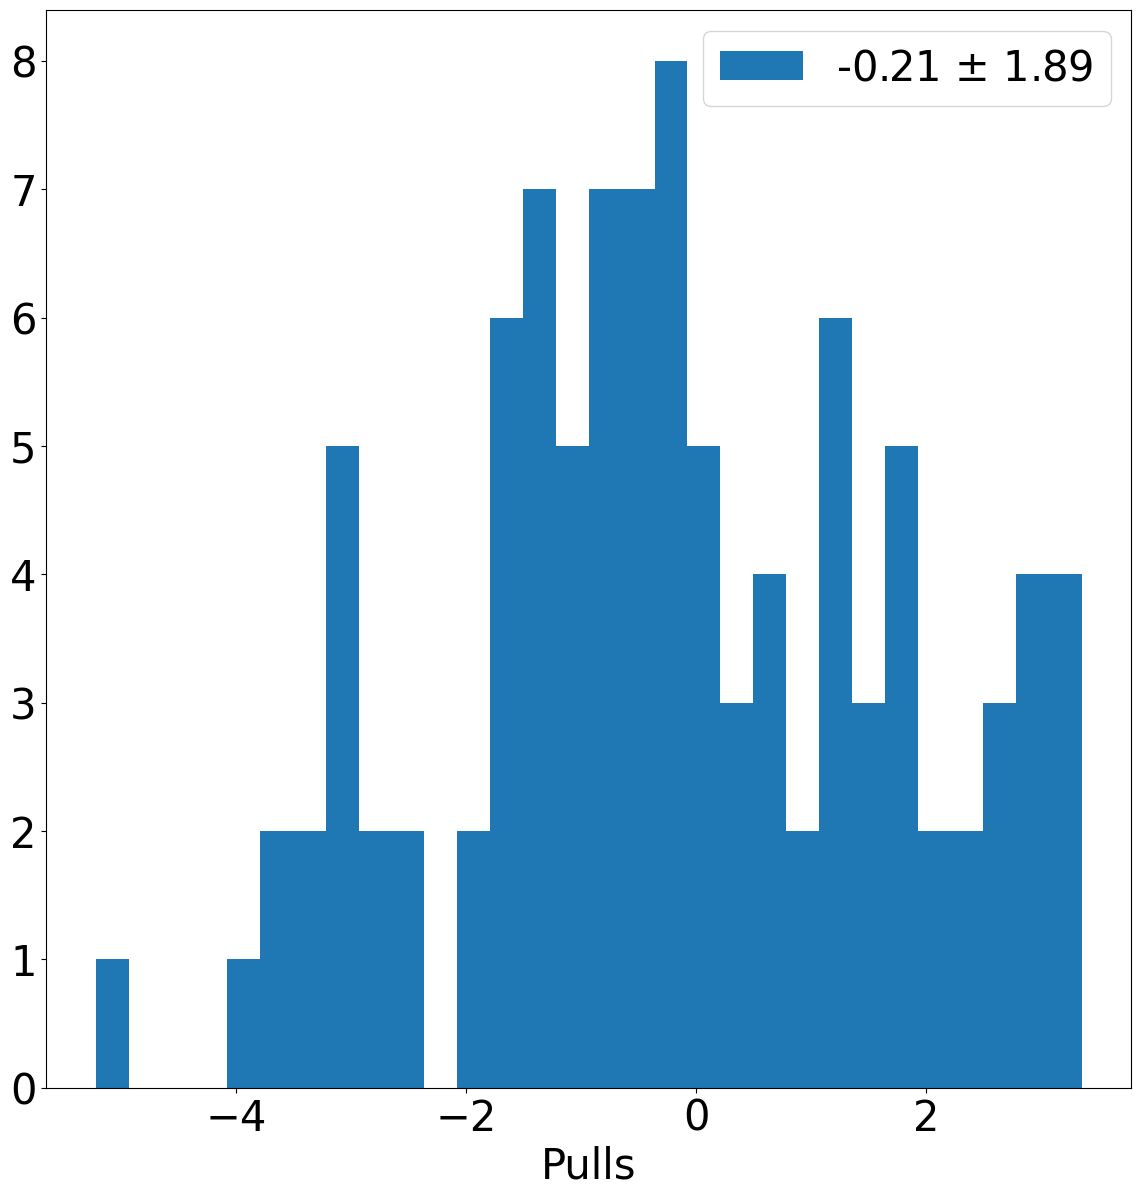

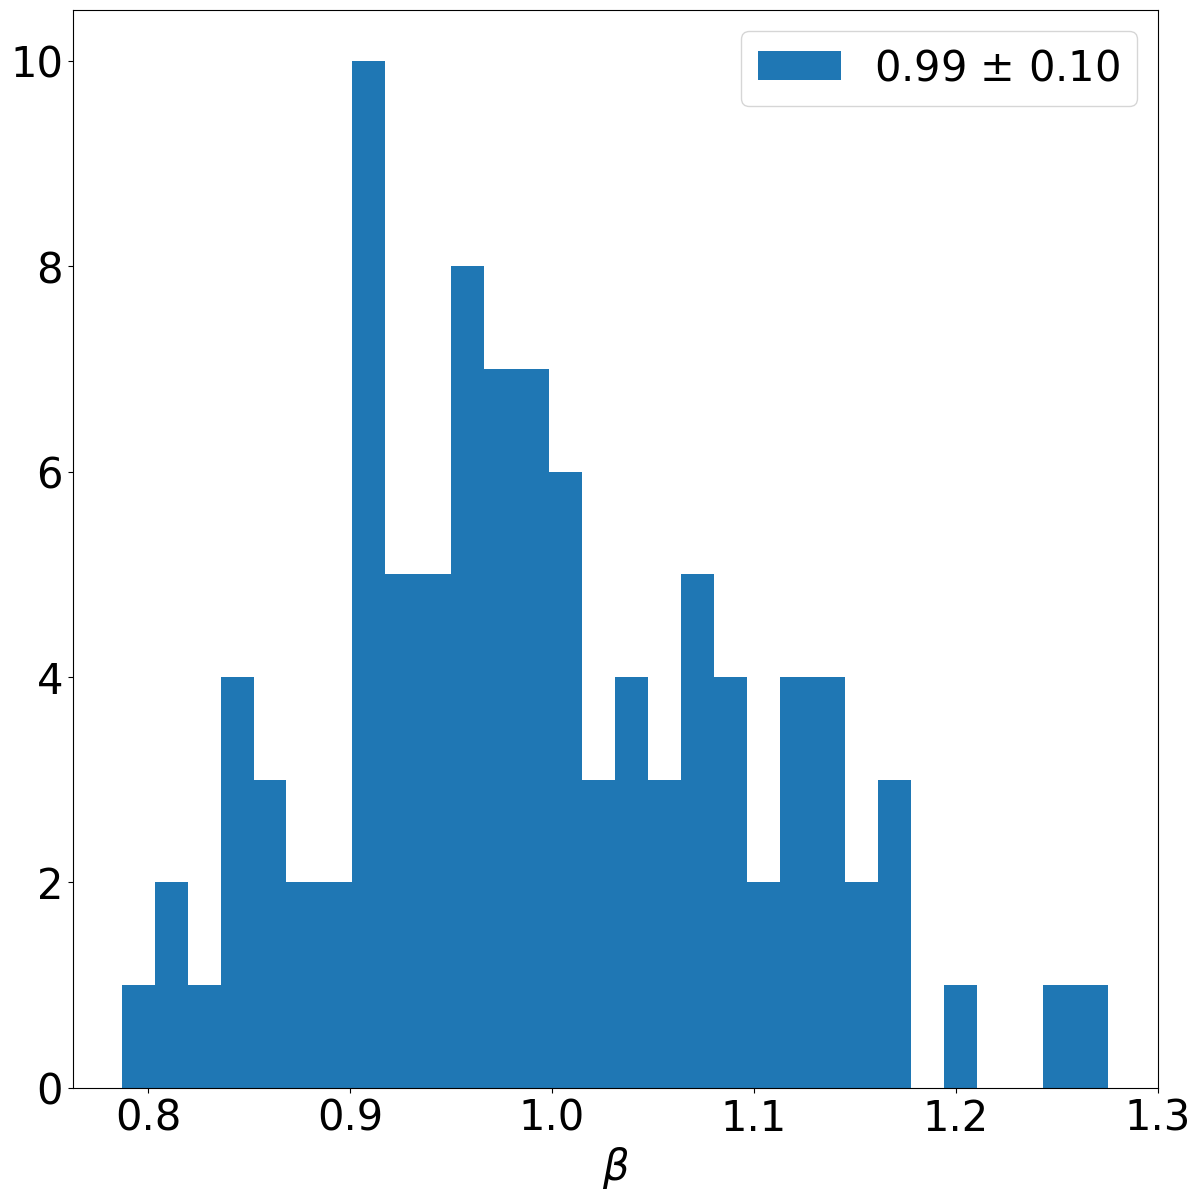

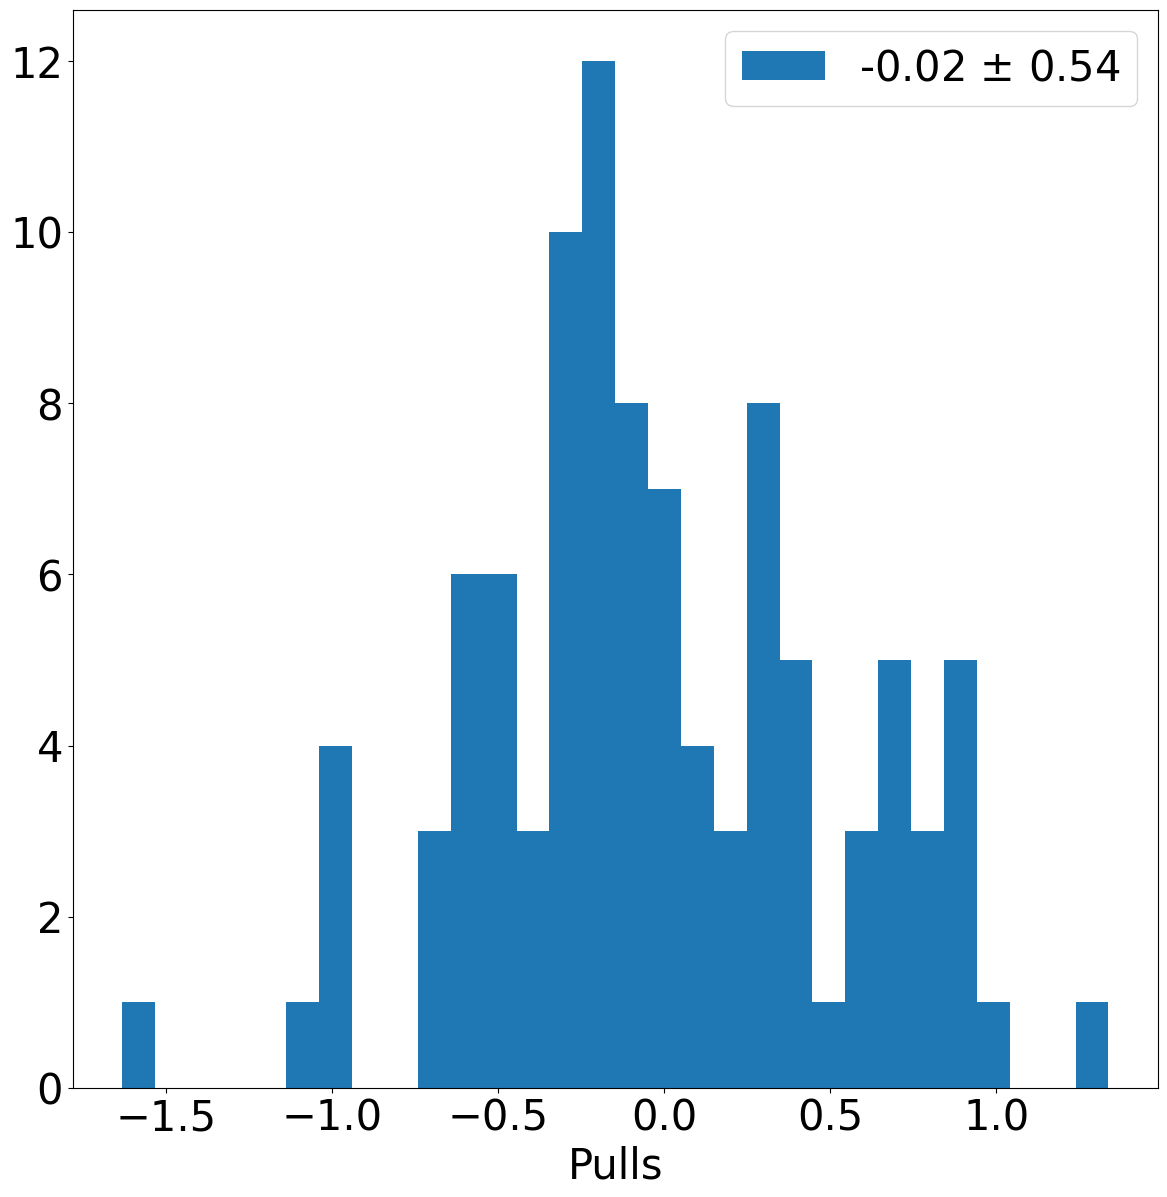

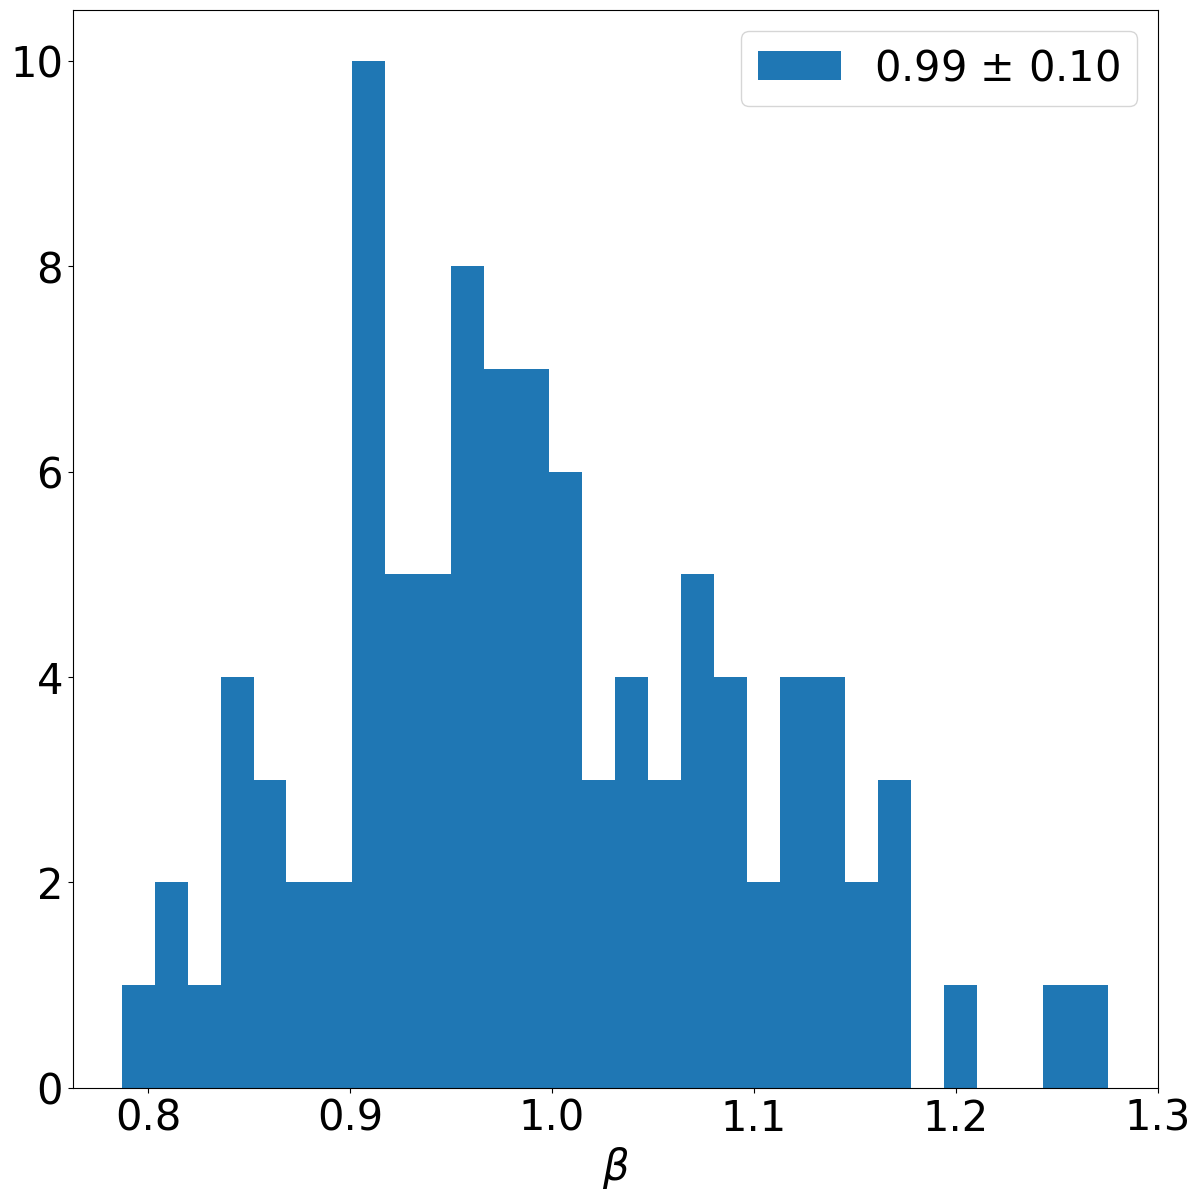

In [72]:
BETAS = betas

def plotComparison(Hists, pars, betas, compareWithBetas=True, morph = []):
    matplotlib.rcParams.update({'font.size': 30})
    binWidths = np.array(combinedBins(Hists.channels))
    binCenters = [np.sum(binWidths[:i]) + binWidths[i]/2 for i in range(len(binWidths))]
    binSides = [np.sum(binWidths[:i]) for i in range(len(binWidths))]
    binSides.append(np.sum(binWidths))

    fig = plt.figure(figsize=(28*binWidths.sum()/800, 14), dpi=100)
    plt.subplots_adjust(hspace=0.0)
    plt.subplot(6, 1, (1, 4))

    # Bootstrap fit uncertainties
    tpars = np.random.multivariate_normal(logL.values, logL.covariance, size=10000)
    
    histEstimate = Hists.getEstimate(pars, betas, morph=morph)
    histEstimateError = Hists.getEstimateUncertainty(pars, betas, morph=morph)
    #tbetas = tpars[:, 8:]
    tmorph = tpars[:, 8:]
    tpars = tpars[:, :8]
    histEstimate = Hists.getEstimate(pars, betas, morph=morph)
    histEstimateError = Hists.getEstimateUncertainty(pars, betas, morph=morph)
    histEstimate = []
    #for p, b in zip(tpars, tbetas):
    for p, m in zip(tpars, tmorph):
        tbetas = BBliteBeta(Hists.DataArray, Hists.getEstimate(p), Hists.getEstimateVariance(p))
        histEstimate.append(Hists.getEstimate(p, tbetas, morph=m))
    histFitUncertainty = np.std(np.array(histEstimate), axis=0)


    histEstimate = Hists.getEstimate(pars, betas, morph=morph)
    histEstimateError = Hists.getEstimateUncertainty(pars, betas, morph=morph)
    #histEstimate, histEstimateError = cos.prediction(pars)
    effectiveHist = np.power(histEstimate/histEstimateError, 2)
    from scipy.stats import gamma
    def poissonErrors(h, cl = 0.68):
        # from: https://root-forum.cern.ch/t/poisson-errors-for-roohist/25688/7
        quantile = (1 - cl)/2
        lower = (h > 0)*gamma.ppf(quantile, h + (h == 0)) # if h == 0, lower = 0
        upper = gamma.isf(quantile, h + 1)*(h > 0) # if h == 0, upper = gamma.isf(quantile, 1
        return h - lower, upper - h

    histEstimateLower, histEstimateUpper = poissonErrors(effectiveHist)
    histEstimateLower = histEstimateLower*histEstimate/effectiveHist
    histEstimateUpper = histEstimateUpper*histEstimate/effectiveHist

    histEstimateUpperTot = np.sqrt(np.power(histEstimateUpper, 2) + np.power(histFitUncertainty, 2))
    histEstimateLowerTot = np.sqrt(np.power(histEstimateLower, 2) + np.power(histFitUncertainty, 2))

    # Plot data and fit
    plt.step(binSides, np.append(histEstimate, histEstimate[-1]), where='post',color = cm.coolwarm(0))
    plt.bar(binCenters, histEstimate, label='Fit', alpha=0.5, color = cm.coolwarm(0),  width=binWidths)
    plt.errorbar(binCenters, Hists.getEstimate(pars, betas, morph=morph), yerr=[histEstimateLowerTot, histEstimateUpperTot], fmt='none', label='Fit uncertainty', color = cm.coolwarm(0))
    plt.errorbar(binCenters, Hists.DataArray, yerr=np.sqrt(Hists.DataArray), label='Data', color = 'black', fmt='o')
    plt.yscale('log')
    plt.xlim(0, binSides[-1])
    plt.gca().axes.xaxis.set_ticklabels([])

    for i in range(len(pars)):
        parsEPC15 = np.zeros(len(pars))
        parsEPC15[i] = pars[i]
        histTempEstimate = Hists.getEstimate(parsEPC15, betas, morph=morph)
        print(BKGnames[i], startingPars[i], '->', np.sum(histTempEstimate), '+-', logL.errors[i]/pars[i]*np.sum(histTempEstimate))
        plt.step(binSides, np.append(histTempEstimate, histTempEstimate[-1]), where='post',color = f'C{i + 1}', linewidth=3, label = BKGnames[i])
    
    for i in range(len(morph)):
        print(alphaNames[i], morph[i], '+-', logL.errors[i + 8])
    
    # Plot a vertical line to separate the Esum bins
    index = 0
    xticks = []
    xtickslabels = []
    for channel in Hists.channels.keys():
        esumBins = np.linspace(Hists.channels[channel]['Esum'][0], Hists.channels[channel]['Esum'][1], Hists.channels[channel]['Esum'][2]+1)
        esumBins = (esumBins[1:] + esumBins[:-1])/2
        minAngle = Hists.channels[channel]['Angle'][0]
        maxAngle = Hists.channels[channel]['Angle'][1]
        for esum in esumBins:
            index = index + Hists.channels[channel]['Angle'][2]
            plt.vlines(binSides[index], 0, 1e5, colors='k', linestyles='dashed')
            # Text inside the box
            xticks.append(0.5*(binSides[index] + binSides[index-Hists.channels[channel]['Angle'][2]]))
            xtickslabels.append(f'{esum:.1f} MeV\n[{minAngle}, {maxAngle}] deg')
    
    plt.legend(loc='upper right', ncol=int(len(BKGnames)*0.5), fontsize=20)
    
    plt.ylim(0.5, 1e5)
    
    plt.subplot(6, 1, (5,6))
    if compareWithBetas:
        histEstimate = Hists.getEstimate(pars, 1, morph=morph)
    
    dDataHist = np.sqrt(Hists.DataArray)
    reddData = dDataHist/(histEstimate + (histEstimate == 0))
    redExpectedFit = histFitUncertainty/(histEstimate + (histEstimate == 0))
    redExpectedHistLower = histEstimateLower/(histEstimate + (histEstimate == 0))
    redExpectedHistUpper = histEstimateUpper/(histEstimate + (histEstimate == 0))
    redExpectedHistLowerTot = histEstimateLowerTot/(histEstimate + (histEstimate == 0))
    redExpectedHistUpperTot = histEstimateUpperTot/(histEstimate + (histEstimate == 0))
    redResiduals = (Hists.DataArray - histEstimate)/(histEstimate + (histEstimate == 0))
    
    redExpectedFit = redExpectedFit/reddData
    redExpectedHistLower = redExpectedHistLower/reddData
    redExpectedHistUpper = redExpectedHistUpper/reddData
    redExpectedHistLowerTot = redExpectedHistLowerTot/reddData
    redExpectedHistUpperTot = redExpectedHistUpperTot/reddData
    redResiduals = redResiduals/reddData
    reddData = reddData/reddData
    
    if compareWithBetas:
        plt.bar(binCenters, redExpectedHistLowerTot + redExpectedHistUpperTot, bottom = -redExpectedHistLowerTot, color = cm.coolwarm(0), alpha=0.5, label='Total model uncertainty', width=binWidths)
        plt.bar(binCenters, redExpectedHistLower + redExpectedHistUpper, bottom = -redExpectedHistLower, color = cm.coolwarm(0.99), alpha=0.5, label='MC statistical uncertainty', width=binWidths)
    else:
        plt.bar(binCenters, 2*redExpectedFit, bottom = -redExpectedFit, color = cm.coolwarm(0), alpha=0.5, label='Fit uncertainty', width=binWidths)
    
    plt.errorbar(binCenters, redResiduals, yerr=reddData, fmt='o', color = 'k', label='Residuals', linewidth=3)
    plt.xlim(0, binSides[-1])
    plt.legend(loc='upper right', fontsize=20)
    plt.ylabel('Red. res.\n' + r'[$\Delta$data]')
    miny = plt.ylim()[0]
    maxy = plt.ylim()[1]
    maxy = np.max([np.abs(miny), np.abs(maxy)])
    miny = -maxy
    index = 0
    for channel in channels.keys():
        esumBins = np.linspace(channels[channel]['Esum'][0], channels[channel]['Esum'][1], channels[channel]['Esum'][2]+1)
        esumBins = (esumBins[1:] + esumBins[:-1])/2
        minAngle = channels[channel]['Angle'][0]
        maxAngle = channels[channel]['Angle'][1]
        for esum in esumBins:
            index = index + channels[channel]['Angle'][2]
            plt.vlines(binSides[index], miny, maxy, colors='k', linestyles='dashed')
    plt.hlines(0, 0, binSides[-1], colors='k', linestyles='dotted')

    plt.ylim(miny, maxy)

    plt.gca().set_xticks(xticks)
    plt.gca().set_xticklabels(xtickslabels, fontsize=20)
    plt.xticks(rotation=45)
    
    fig = plt.figure(figsize=(14, 14), dpi=100)
    if compareWithBetas:
        pulls = (Hists.DataArray - histEstimate)/np.sqrt(dDataHist**2 +  + histEstimateError**2  + (dDataHist == 0)) * (dDataHist > 0)
    else:
        pulls = (Hists.DataArray - histEstimate)/np.sqrt(dDataHist**2 + (dDataHist == 0)) * (dDataHist > 0)# + histEstimateError**2  + (histEstimate == 0))
    pulls = pulls[Hists.DataArray != 0]
    plt.hist(pulls, label= f'{pulls.mean():.2f} $\pm$ {pulls.std():.2f}', bins=30)
    plt.legend()
    plt.xlabel('Pulls')
    print('chi2:', np.sum(pulls**2))
    print('dof:', len(pulls) - len(pars))
    pvalue = chi2.sf(np.sum(pulls**2), len(pulls) - len(pars))
    print('p-value:', pvalue)
    zscore = norm.isf(pvalue)
    print('Z-score:', zscore)
    
    fig = plt.figure(figsize=(14, 14), dpi=100)
    plt.hist(betas[Hists.DataArray != 0], bins=30, label=f'{betas.mean():.2f} $\pm$ {betas.std():.2f}')
    plt.legend()
    plt.xlabel(r'$\beta$')
    
    
        
plotComparison(Hists, pars, betas, compareWithBetas=True)
plotComparison(Hists, pars, betas, compareWithBetas=False)

Do Minos plot

In [73]:
#for name in logL.parameters:
#    matplotlib.rcParams.update({'font.size': 30})
#    fig = plt.figure(figsize=(21, 14), dpi=100)
#    logL.draw_profile(name)
#    plt.ylim(0, plt.gca().get_ylim()[1])
#plt.plot(logL.values['nEPC15'], logL.values['nEPC18'], 'o', label='Best fit')


In [74]:
#%%capture --no-display
## Draw contours
#matplotlib.rcParams.update({'font.size': 25})
#fig = plt.figure(figsize=(50, 50), dpi=100)
#plt.set_cmap('Set1')
#plt.subplot(8, 8, 1)
#
#maxX = np.zeros(8)
#minX = np.zeros(8) + 1e9
#maxY = np.zeros(8)
#minY = np.zeros(8) + 1e9
#
#for i in range(8):
#    for j in range(8):
#        if i > j:
#            try:
#                plt.subplot(8, 8, 8*i + j + 1)
#                logL.draw_mncontour(logL.parameters[j], logL.parameters[i], cl=[1,2,3])
#                #logL.draw_contour(logL.parameters[j], logL.parameters[i], cl=[1,2,3])
#                plt.xlabel(logL.parameters[j])
#                plt.ylabel(logL.parameters[i])
#                plt.plot(logL.values[logL.parameters[j]], logL.values[logL.parameters[i]], '+', label='Best fit', markersize = 25)
#            except:
#                plt.plot(logL.values[logL.parameters[j]], logL.values[logL.parameters[i]], '+', label='Best fit', markersize = 25)
#            if minX[j] > plt.gca().get_xlim()[0]:
#                minX[j] = plt.gca().get_xlim()[0]
#            if maxX[j] < plt.gca().get_xlim()[1]:
#                maxX[j] = plt.gca().get_xlim()[1]
#            if minY[i] > plt.gca().get_ylim()[0]:
#                minY[i] = plt.gca().get_ylim()[0]
#            if maxY[i] < plt.gca().get_ylim()[1]:
#                maxY[i] = plt.gca().get_ylim()[1]
#            if j != 0:
#                plt.gca().axes.yaxis.set_ticklabels([])
#                plt.gca().axes.yaxis.set_ticks([])
#            if i != 7:
#                plt.gca().axes.xaxis.set_ticklabels([])
#                plt.gca().axes.xaxis.set_ticks([])
#        elif i == j:
#            plt.subplot(8, 8, 8*i + j + 1)
#            logL.draw_mnprofile(logL.parameters[j])
#            plt.vlines(logL.values[logL.parameters[j]], 0, plt.gca().get_ylim()[1], label='Best fit')
#            plt.legend()
#            plt.xlabel(logL.parameters[j])
#            plt.gca().set_title(logL.parameters[j] + ' = ' + f'{logL.values[logL.parameters[j]]:.2e}')
#            if minX[j] > plt.gca().get_xlim()[0]:
#                minX[j] = plt.gca().get_xlim()[0]
#            if maxX[j] < plt.gca().get_xlim()[1]:
#                maxX[j] = plt.gca().get_xlim()[1]
#for i in range(8):
#    for j in range(8):
#        if i >= j:
#            plt.subplot(8, 8, 8*i + j + 1)
#            if i != j:
#                plt.ylim(0.9*minY[i], maxY[i]*1.1)
#                plt.xlim(0.9*minX[j], maxX[j]*1.1)
#            else:
#                plt.ylim(0, plt.gca().get_ylim()[1])
#            
#
#plt.text(0.65, 0.65, 'Profile\nlikelihoods', fontsize=100, ha='center', va='center', transform=plt.gcf().transFigure)
#print(minX, maxX, minY, maxY)


## Toy MCs

/var/folders/tt/yr5h_pkx6pj1f0zdwb_lgyp40000gn/T/ipykernel_923/1865714829.py:19: RuntimeWarning: invalid value encountered in scalar divide
  p181 = nIPC181/(nIPC181 + nIPC151)


516.8787040994174
[]
[]
(array([], dtype=int64),)
9
10
7 2
[ True False False  True False False False False False  True] [ True  True  True  True  True  True  True  True False False]
9
[]


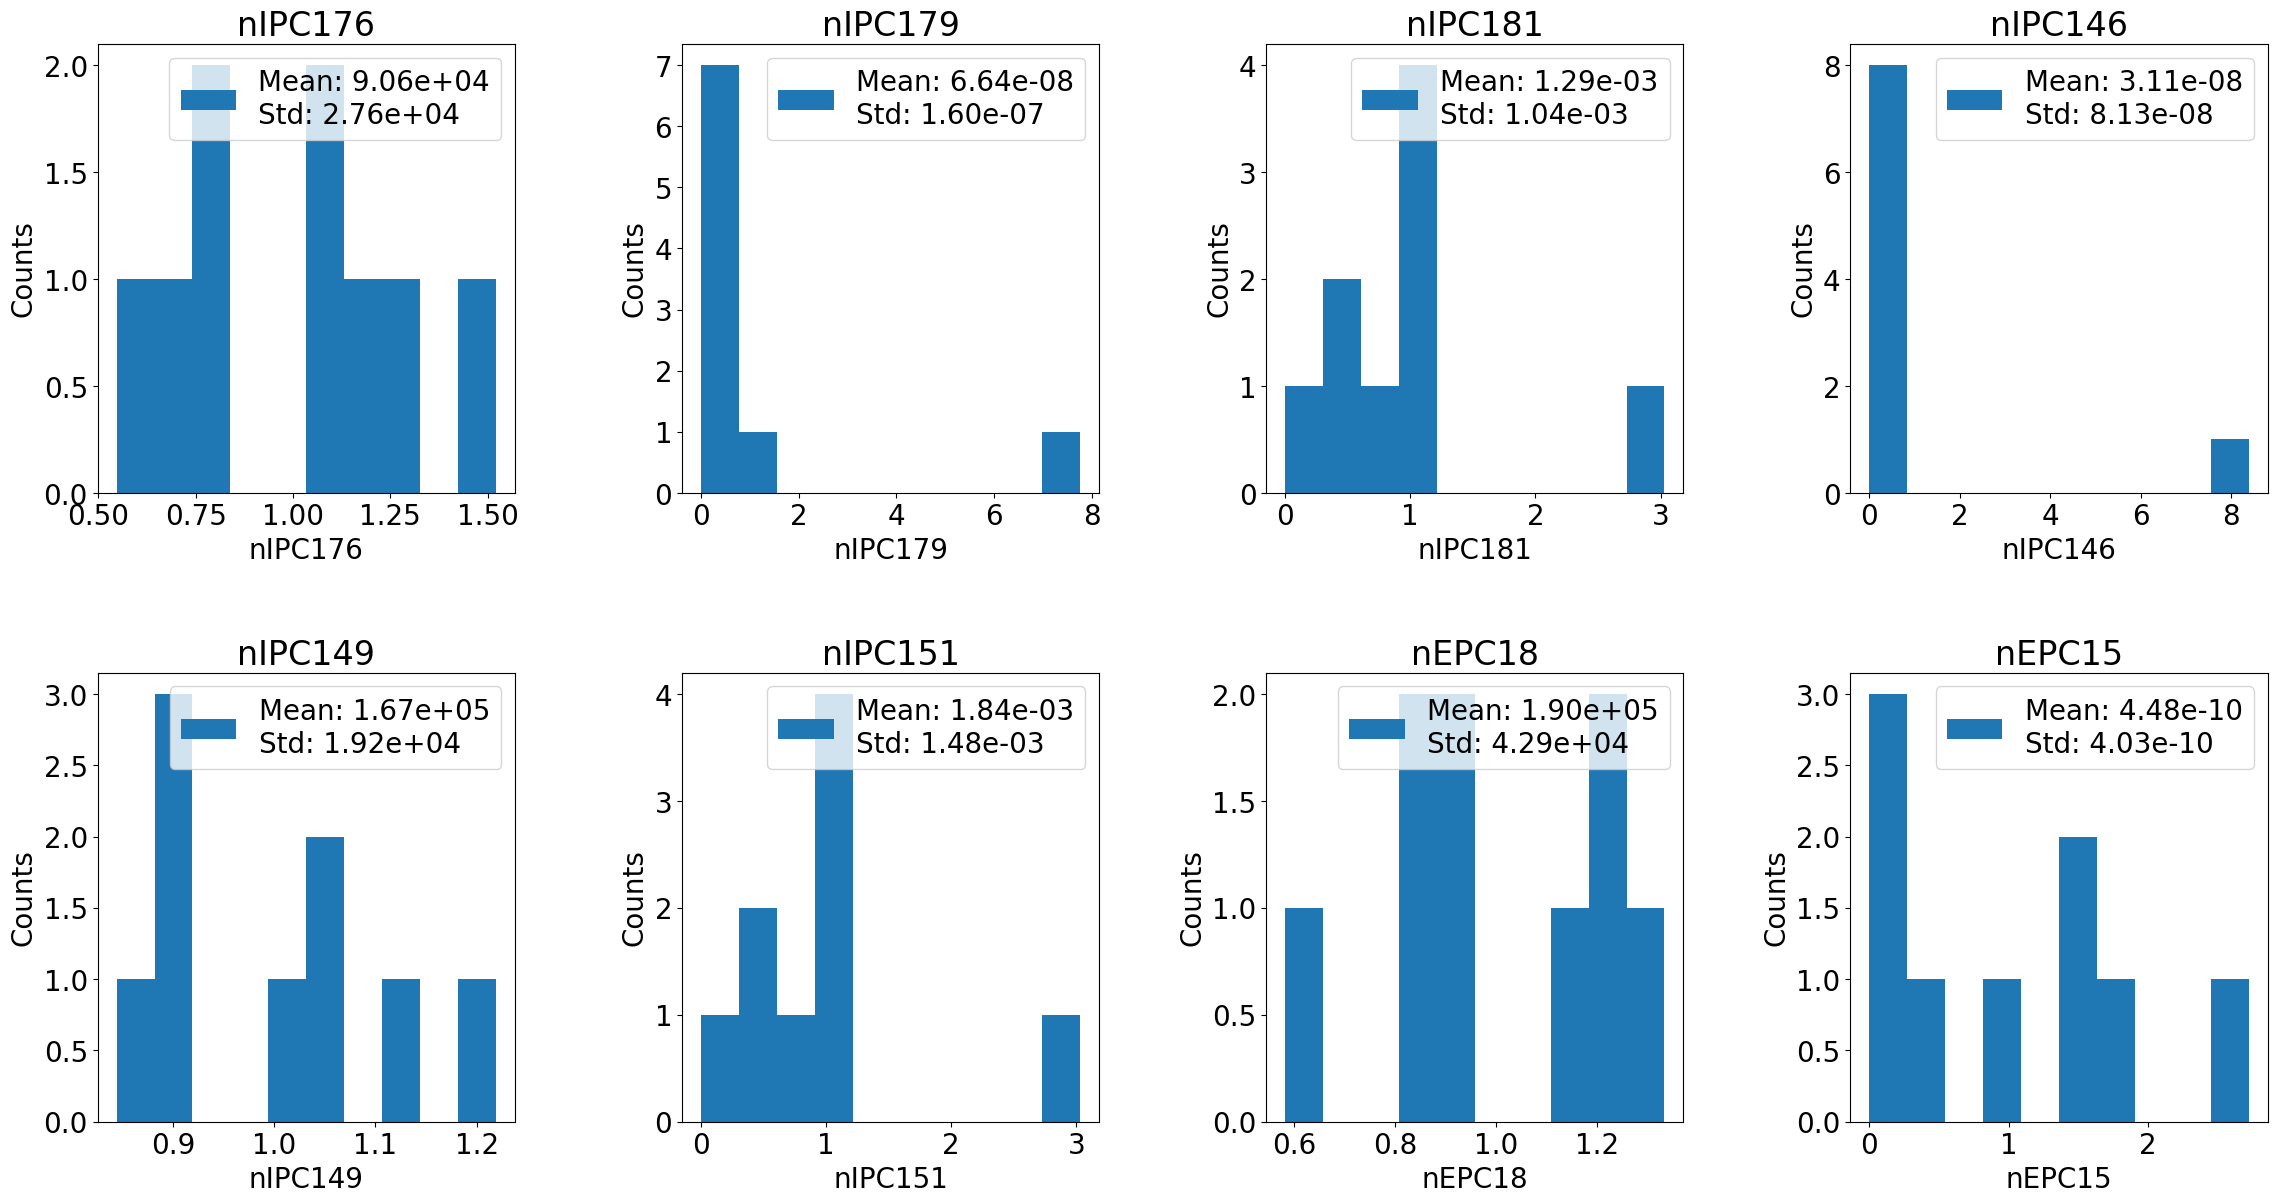

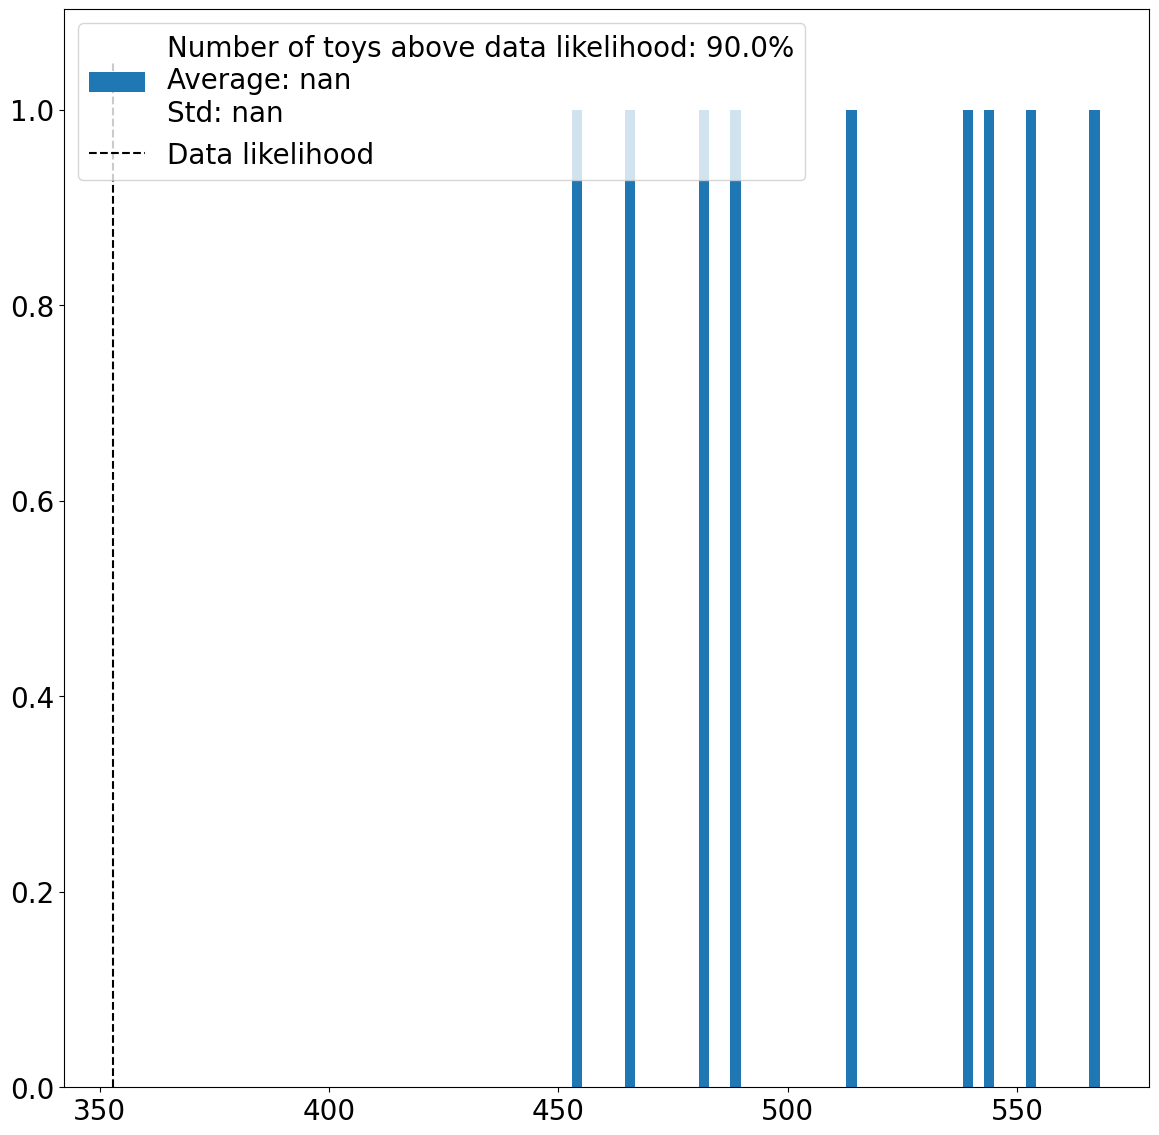

In [75]:
matplotlib.rcParams.update({'font.size': 20})

def generateToy(Hists, betas, pars):
    dataToy = np.random.poisson(Hists.getEstimate(pars, betas))
    return dataToy

def llBKGToy(pars):
    nIPC176, nIPC179, nIPC181, nIPC146, nIPC149, nIPC151, nEPC18, nEPC15 = pars
    yields = np.array([nIPC176, nIPC179, nIPC181, nIPC146, nIPC149, nIPC151, nEPC18, nEPC15])
    mu0 = Hists.getEstimateToy(yields)
    Vmu0 = Hists.getEstimateVarianceToy(yields)
    mueff = np.power(mu0, 2)/(Vmu0 + (mu0==0))
    betas = BBliteBeta(Hists.DataArrayToy, mu0, mueff)
    
    mu = Hists.getEstimateToy(yields, betas)
    
    p176 = nIPC176/(nIPC176 + nIPC146)
    p179 = nIPC179/(nIPC179 + nIPC149)
    p181 = nIPC181/(nIPC181 + nIPC151)
    
    nomp176 = 2.8/(1 + 2.8)
    nomp179 = 0.8/(1 + 0.8)
    nomp181 = 0.7/(1 + 0.7)
    
    return likelihood(Hists.DataArrayToy, 0, mu, mueff, betas, 0) + np.power((p176 - nomp176)/0.1, 2) + np.power((p179 - nomp179)/0.1, 2) + np.power((p181 - nomp181)/0.1, 2)

PARS = []
Likelihood = []
Accurate = []
Valid = []
for i in range(10):
#for i in range(3047, 3048):
    np.random.seed(i)
    # Create copy of the Hists object
    tpars = np.random.multivariate_normal(pars, covariance)
    Hists.generateToy(tpars, betas = betas, fluctuateTemplates = True)
    logL = Minuit(llBKGToy, tpars, name=['nIPC176', 'nIPC179', 'nIPC181', 'nIPC146', 'nIPC149', 'nIPC151', 'nEPC18', 'nEPC15'])
    for j in range(len(pars)):
        logL.limits[j] = (0, None)
    logL.simplex(ncall=100000)
    logL.strategy = 2
    logL.tol = 1e-10
    logL.migrad(ncall=100000, iterate=5)
    
    if (not logL.valid):
        I = 0
        while(not logL.valid):
            logL.simplex(ncall=100000)
            #for j in range(5):
            #    logL.scan(ncall=1e4)
            logL.strategy = 2
            logL.tol = 1e-10
            logL.migrad(ncall=100000, iterate=5)
            I += 1
            if I == 10:
                break
    logL.hesse()
    PARS.append(np.array(logL.values))
    Likelihood.append(logL.fval)
    Accurate.append(logL.accurate)
    Valid.append(logL.valid)

#print(logL.fval)
PARS = np.array(PARS)
Likelihood = np.array(Likelihood)
Valid = np.array(Valid)
Accurate = np.array(Accurate)

print(np.mean(Likelihood[Valid == True]))
print(Valid[Likelihood > 2000])
print(Likelihood[Likelihood > 2000])
print(np.where(Likelihood > 2000))
print(len(Likelihood[Likelihood < 10000]))
print(len(Likelihood))
print(len(Valid[Valid==False]), len(Accurate[Accurate==False]))
print(Valid, Accurate)

fig = plt.figure(figsize=(28, 14), dpi=100)
plt.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(len(logL.parameters)):
    plt.subplot(2, 4, i+1)
    tpars = np.array([p[i] for p in PARS[Likelihood < 10000]])
    plt.hist(tpars/tpars.mean(), label= f'Mean: {tpars.mean():.2e}\nStd: {tpars.std():.2e}')
    plt.xlabel(logL.parameters[i])
    plt.ylabel('Counts')
    plt.legend()
    plt.title(logL.parameters[i])

fig = plt.figure(figsize=(14, 14), dpi=100)
plt.hist(Likelihood[Likelihood < 10000], label= 'Number of toys above data likelihood: ' + f'{np.sum(np.array(Likelihood) > MAXLikelihood)/len(Likelihood)*100:.1f}%' + f'\nAverage: {np.mean(Likelihood):.2e}\nStd: {np.std(Likelihood):.2e}', bins=50)
plt.vlines(MAXLikelihood, 0, plt.gca().get_ylim()[1], label='Data likelihood', color='k', linestyles='dashed')
plt.legend()

print(len(Likelihood[Likelihood < 10000]))
print(PARS[Likelihood > 10000])
# Save parameters and likelihood with numpy seed to reproduce
np.save('toyParameters.npy', zip(np.linspace(0, len(PARS), len(PARS)), PARS, Likelihood))

# Template morphing

Systematic effects affecting the shape of the templates are included through morphing. For some reference values of the systematic uncertainty in exam,  the templates are comoputed and then interpolated. Usually this is done for the nominal value and the +-1 sigma variations on that systematic. There are different approaches to perform the interpolation:
* Vertical morphing: the templates are interpolated on a binwise basis, so that bin $i$ of the morphed template is the weighted sum only of bin $i$ in the reference templates. This is the most straightforward approach but has a fallback: if the reference templates are far apart in the evalutaion points, the interpolation in between ranges can result in multi-modal distributions.
* Horizontal morphing: the interpolation is done on the inverse of the cumulative distributions. This allows to shift the mean and the variance of the distributions and correctly interpolate between them. In the literature this is referred to as "expensive" computationally. In numpy the operation of creating a distribution from a cumulative distribution is rather quick, so we could try it. It does not have a natural extensio to higher dimensional histograms, but one can still try building a monodimensional cumulative out of our 2D distributions. This introduces correlations between the bins, so the complete BB likelihood cannot be simplified to a set of independent equations anymore.
* Moment morphing: the interpolation is still vertical, but before summing the weighted bins they are shifted and scaled so that the mean and variance of the distributions are the same and correspond to their weighted average. This naturally allows an extension to higher dimension histograms. The way to combine and scale neighboring bins is not unique, so one needs to make a choice.

Vertical morphing seems good enough with the implementation from https://arxiv.org/pdf/1410.7388.pdf.

## MorphTemplate1D class test

(2, 8, 11, 100)


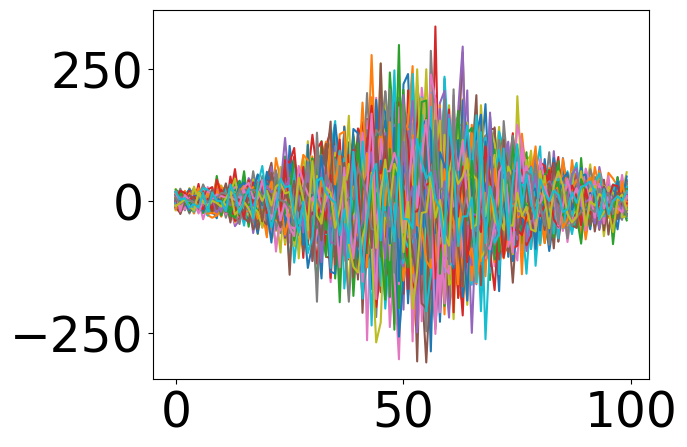

(2, 8, 11, 100)
(11, 100)


/var/folders/tt/yr5h_pkx6pj1f0zdwb_lgyp40000gn/T/ipykernel_923/4253790709.py:156: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


<Figure size 2100x700 with 0 Axes>

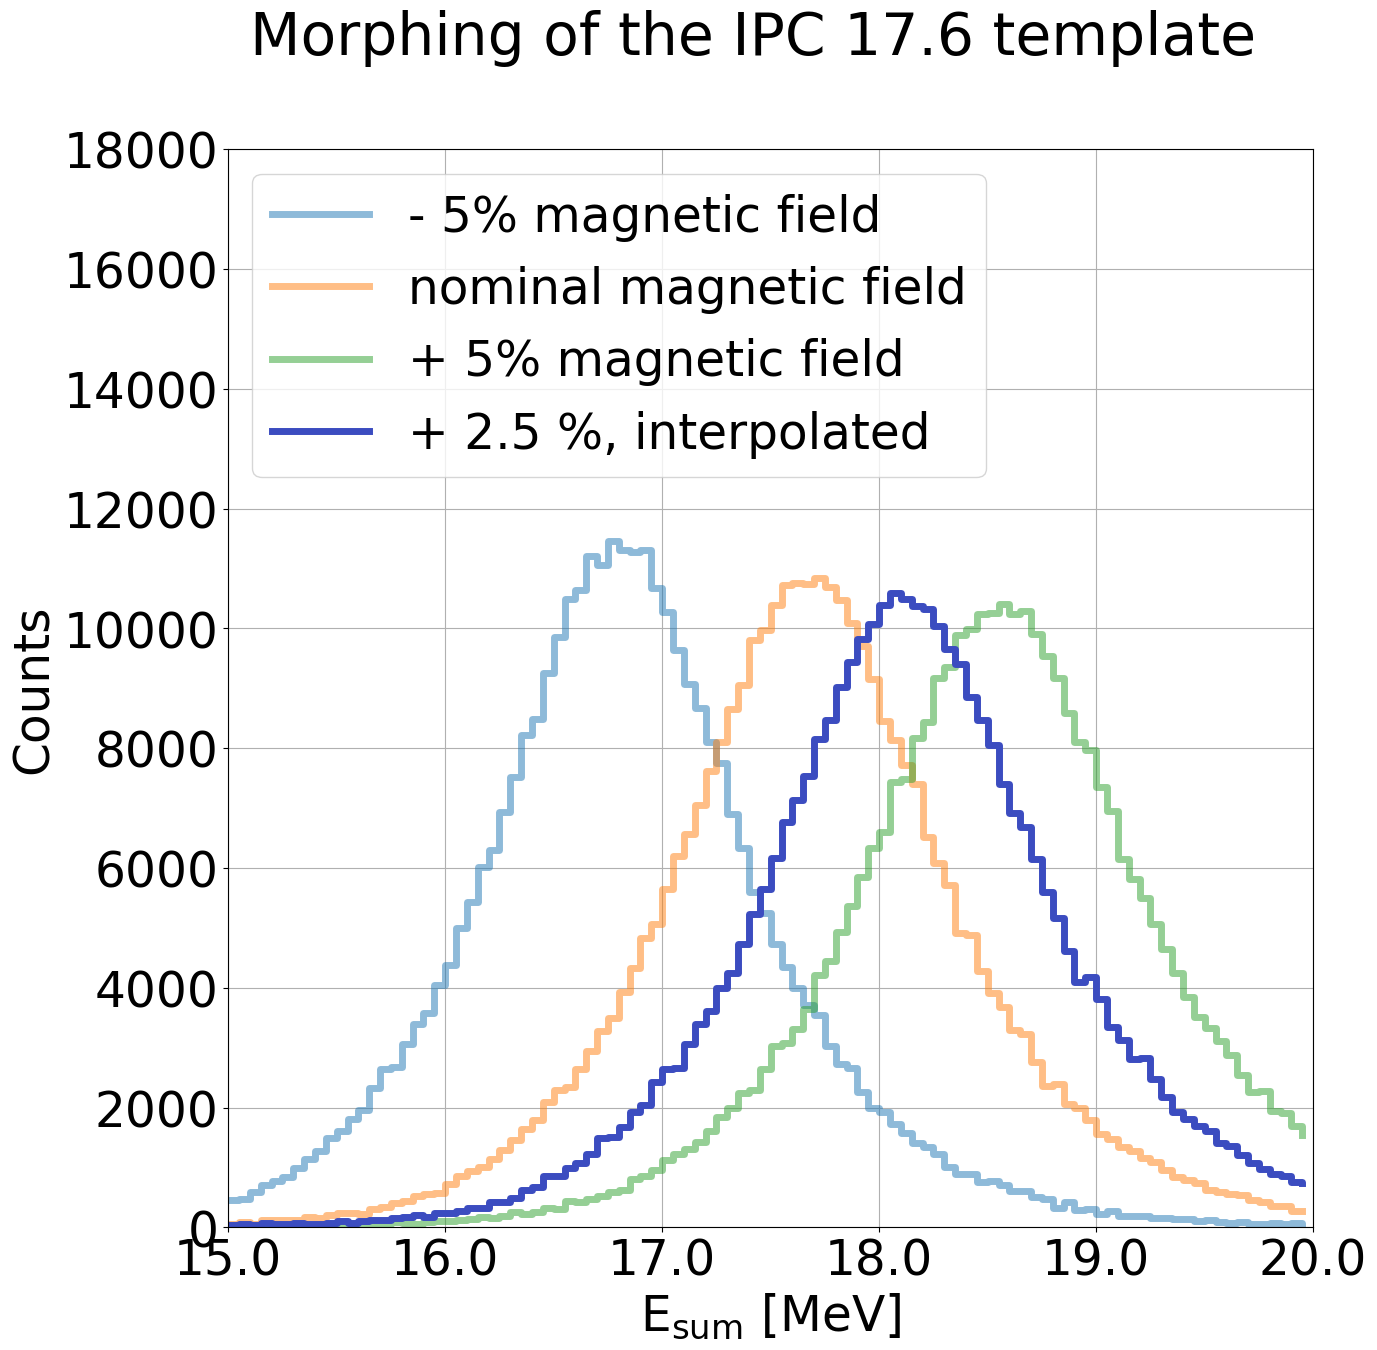

interactive(children=(FloatSlider(value=0.0, description='alphares', max=1.0, min=-1.0), FloatSlider(value=0.0…

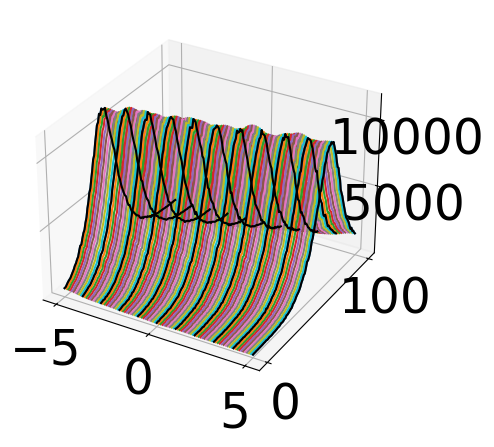

In [76]:
# Interactive plot
#%matplotlib inline
from importlib import reload
reload(plt)
from ipywidgets import *
matplotlib.rcParams.update({'font.size': 35})
from scipy.interpolate import interp1d

import time
BKG = 0
print(Hists.BKGarrayNuisance5Sigma.shape)
for i in range(100):
    np.random.seed(i)
    Hists.generateToy(pars, betas = betas, fluctuateTemplates = True, morph = [0,0])
    #plt.plot(np.arange(len(Hists.BKGarrayNuisance5SigmaToy[0, 1, 0])), Hists.BKGarrayNuisance5SigmaToy[0, 1, 0])
    #temp = Hists.getMorphedBKGarrayToy(morph = [0, 0])[BKG] - Hists.BKGarrayToy[BKG]
    temp = Hists.BKGarray[BKG] - Hists.BKGarrayToy[BKG]
    Hists.BKGarrayNuisance5Sigma[1, BKG, 3, :]
    #temp = Hists.BKGarrayNuisance5Sigma[1, BKG, int(len(Hists.BKGarray)/2) + 1, :] - Hists.BKGarray[BKG]
    plt.plot(np.arange(len(temp)), temp)
    #plt.plot(np.arange(len(Hists.BKGarrayNuisance5SigmaArrayToy[0, 1])), Hists.BKGarrayNuisance5SigmaArrayToy[0, 1])
#plt.hist(((Hists.BKGarrayNuisance5Sigma - Hists.BKGarrayNuisance5SigmaToy)/(Hists.BKGarrayNuisance5Sigma + (Hists.BKGarrayNuisance5Sigma == 0))).flatten(), bins=100, label='Toy')
#plt.hist(((Hists.BKGarray - Hists.BKGarrayToy)/(Hists.BKGarray + (Hists.BKGarray == 0))).flatten(), bins=100, label='Toy')
#plt.plot(np.arange(len(Hists.BKGarrayNuisance5Sigma[1, BKG, 0, :])), Hists.BKGarrayNuisance5Sigma[1, BKG, 0, :], label='Data', color='k')
plt.show()
print(Hists.BKGarrayNuisance5Sigma.shape)

hists = np.array([Hists.BKGarrayNuisance5Sigma[1, BKG, 3, :], Hists.BKGarrayNuisance5Sigma[1, BKG, 4, :], Hists.BKGarrayNuisance5Sigma[1, BKG, 5, :], Hists.BKGarrayNuisance5Sigma[1, BKG, 6, :], Hists.BKGarrayNuisance5Sigma[1, BKG, 7, :]])
hists = np.array(Hists.BKGarrayNuisance5Sigma[1, BKG, :, :])
hists = np.array(Hists.BKGarrayNuisance5SigmaToy[1, BKG, :, :])
#hists = Hists.BKGarrayNuisance5Sigma[1, :]
#hists = np.swapaxes(hists, 1, 2)
#hists = np.concatenate(hists, axis=0)
#hists = np.swapaxes(hists, 0, 1)
print(hists.shape)
#hists = np.array([Hists.BKGarrayNuisance5Sigma[1, BKG, 0, :], Hists.BKGarrayNuisance5Sigma[1, BKG, 5, :], Hists.BKGarrayNuisance5Sigma[1, BKG, 10, :]])
hists = np.swapaxes(hists, 0, 1)
#hists = hists/np.sum(hists, axis=0)
hists = np.swapaxes(hists, 0, 1)

morpher = MorphTemplate1D(hists, np.linspace(-5, 5, len(hists)), 0)

hists1 = np.array([Hists.BKGarrayNuisance5Sigma[1, BKG, 3, :], Hists.BKGarrayNuisance5Sigma[1, BKG, 4, :], Hists.BKGarrayNuisance5Sigma[1, BKG, 5, :], Hists.BKGarrayNuisance5Sigma[1, BKG, 6, :], Hists.BKGarrayNuisance5Sigma[1, BKG, 7, :]])
hists1 = np.array(Hists.BKGarrayNuisance5Sigma[1, BKG, 0:5, :])
#hists = np.array([Hists.BKGarrayNuisance5Sigma[1, BKG, 0, :], Hists.BKGarrayNuisance5Sigma[1, BKG, 5, :], Hists.BKGarrayNuisance5Sigma[1, BKG, 10, :]])
hists1 = np.swapaxes(hists1, 0, 1)
#hists = hists/np.sum(hists, axis=0)
hists1 = np.swapaxes(hists1, 0, 1)

morpher1 = MorphTemplate1D(hists1, np.linspace(-5, -1, len(hists1)), 0)

hists2 = np.array([Hists.BKGarrayNuisance5Sigma[1, BKG, 3, :], Hists.BKGarrayNuisance5Sigma[1, BKG, 4, :], Hists.BKGarrayNuisance5Sigma[1, BKG, 5, :], Hists.BKGarrayNuisance5Sigma[1, BKG, 6, :], Hists.BKGarrayNuisance5Sigma[1, BKG, 7, :]])
hists2 = np.array(Hists.BKGarrayNuisance5Sigma[1, BKG, 6:11, :])
#hists = np.array([Hists.BKGarrayNuisance5Sigma[1, BKG, 0, :], Hists.BKGarrayNuisance5Sigma[1, BKG, 5, :], Hists.BKGarrayNuisance5Sigma[1, BKG, 10, :]])
hists2 = np.swapaxes(hists2, 0, 1)
#hists = hists/np.sum(hists, axis=0)
hists2 = np.swapaxes(hists2, 0, 1)

morpher2 = MorphTemplate1D(hists2, np.linspace(1, 5, len(hists2)), 0)

#morpher = MorphTemplate1D(Hists.BKGarrayNuisance[1, 7, :, :], np.array([-1, 0, 1]), 0)
f = interp1d(np.arange(11), np.sum(Hists.BKGarrayNuisance5Sigma[1, BKG, :, :], axis=1), kind='linear', fill_value='extrapolate')
from scipy.interpolate import interp1d
zero = Hists.BKGarrayNuisanceCumSum[1, 7, 0, :]/float(Hists.BKGarrayNuisanceCumSum[1, 7, 0, -1])
one = np.arange(len(Hists.DataArray))
idx = np.unique(zero, return_index=True)[1]
zero = zero[idx]
one = one[idx]
interp1dCumSum = interp1d(zero, one, kind='linear', fill_value='extrapolate')
hist0 = interp1dCumSum(np.linspace(0, 1, 1000))

zero = Hists.BKGarrayNuisanceCumSum[1, 7, 1, :]/float(Hists.BKGarrayNuisanceCumSum[1, 7, 1, -1])
one = np.arange(len(Hists.DataArray))
idx = np.unique(zero, return_index=True)[1]
zero = zero[idx]
one = one[idx]
interp1dCumSum = interp1d(zero, one, kind='linear', fill_value='extrapolate')
hist1 = interp1dCumSum(np.linspace(0, 1, 1000))

zero = Hists.BKGarrayNuisanceCumSum[1, 7, 2, :]/float(Hists.BKGarrayNuisanceCumSum[1, 7, 2, -1])
one = np.arange(len(Hists.DataArray))
idx = np.unique(zero, return_index=True)[1]
zero = zero[idx]
one = one[idx]
interp1dCumSum = interp1d(zero, one, kind='linear', fill_value='extrapolate')
hist2 = interp1dCumSum(np.linspace(0, 1, 1000))

morpherCumSum = MorphTemplate1D(np.array([hist0, hist1, hist2]), np.array([-1, 0, 1]), 0)

def getECP15Morph(alphares, alphafield):
    '''
    if alphafield < -2:
        h = morpher1.morphTemplate(alphafield)
    elif alphafield < -1:
        h = morpher1.morphTemplate(alphafield) + morpher.morphTemplate(alphafield)
        h *= 0.5
    elif alphafield < 1:
        h = morpher.morphTemplate(alphafield)
    elif alphafield < 2:
        h = morpher2.morphTemplate(alphafield) + morpher.morphTemplate(alphafield)
        h *= 0.5
    else:
        h = morpher2.morphTemplate(alphafield)
    '''
    h = morpher.morphTemplate(alphafield)
    #h = Hists.getMorphedBKGarrayToy(morph = [alphares, alphafield])[BKG]
    return h#*f(0)#*f(alphafield)/h.sum()

def getECP15CumSumMorph(alphares, alphafield):
    hist = morpherCumSum.morphTemplate(alphafield)
    interp1dCumSum = interp1d(hist, np.linspace(0, 1, 1000), kind='linear', fill_value='extrapolate')
    hist = interp1dCumSum(np.arange(len(hists[0])))
    hist = np.concatenate([[0], hist])
    hist = np.diff(hist)
    return hist

fig = plt.figure(figsize=(21, 7))
fig = plt.figure(figsize=(14, 14))
plt.suptitle('Morphing of the ' + BKGnames[BKG] + ' template')
#ax = fig.add_subplot(121)
ax = fig.add_subplot(111)

plt.step(np.arange(len(hists[0])), hists[0, :], where='post', label='- 5% magnetic field', alpha=0.5, linewidth=5)

#plt.step(np.arange(len(hists[0])), hists[1, :], where='post', label='0')

#plt.step(np.arange(len(hists[0])), hists[2, :], where='post', label='up')

#plt.step(np.arange(len(hists[0])), hists[3, :], where='post', label='dn')

#plt.step(np.arange(len(hists[0])), hists[4, :], where='post', label='0')

plt.step(np.arange(len(hists[0])), hists[5, :], where='post', label='nominal magnetic field', alpha=0.5, linewidth=5)

#plt.step(np.arange(len(hists[0])), hists[6, :], where='post', label='dn')

#plt.step(np.arange(len(hists[0])), hists[7, :], where='post', label='0')

#plt.step(np.arange(len(hists[0])), hists[8, :], where='post', label='up')

#plt.step(np.arange(len(hists[0])), hists[9, :], where='post', label='dn')

plt.step(np.arange(len(hists[0])), hists[10, :], where='post', label='+ 5% magnetic field', alpha=0.5, linewidth=5)

line1, = ax.step(np.arange(len(hists[0])), getECP15Morph(0, 2.5), where='post',color = cm.coolwarm(0), label='+ 2.5 %, interpolated', linewidth=5)
#ax.step(np.arange(len(hists[0])), Hists.BKGarrayToy[BKG], where='post',color = 'k', label='+ 2.5%')


plt.ylabel('Counts')
plt.xlabel('bin')
plt.xlabel(r'$\mathrm{E_{sum}}$ [MeV]')
plt.xlim(0, len(hists[0]))
labels = [item.get_text() for item in ax.get_xticklabels()]
## Change label range to 10-24
labels = [f'{float(label):.1f}' for label in np.linspace(15, 20, len(labels))]
ax.set_xticklabels(labels)
plt.legend(loc = 'upper left')
#plt.yscale('log')
#plt.xlim(100, None)
plt.ylim(0, 18000)
plt.grid()
'''
ax1 = plt.subplot(122)

nTrials = 101
y = []
startTime = time.time()
for i in np.linspace(-5, 5, nTrials):
    #morpher = MorphTemplate1D(hists, np.linspace(-5, 5, len(hists)), 0)
    #morpher = MorphTemplate1D(hists, np.linspace(-5, 5, len(hists)), 0)
    y.append(np.sum(getECP15Morph(0, i)))
print('Time:', time.time() - startTime)
#line2, = ax1.step(np.arange(len(hists[0])), getECP15CumSumMorph(0, 0), where='post',color = cm.coolwarm(0), label='EPC15')
#plt.step(np.arange(len(hists[0])), Hists.BKGarrayNuisanceCumSum[1, 7, 0, :]/Hists.BKGarrayNuisanceCumSum[1, 7, 0, -1], where='post', label='dn')

#plt.step(np.arange(len(hists[0])), Hists.BKGarrayNuisanceCumSum[1, 7, 1, :]/Hists.BKGarrayNuisanceCumSum[1, 7, 1, -1], where='post', label='0')

#plt.step(np.arange(len(hists[0])), Hists.BKGarrayNuisanceCumSum[1, 7, 2, :]/Hists.BKGarrayNuisanceCumSum[1, 7, 2, -1], where='post', label='up')

#plt.plot(np.arange(11), np.sum(Hists.BKGarrayNuisance5Sigma[1, BKG, :, :], axis=1), label='Sum')


#plt.plot(np.linspace(0, 10, 1000), f(np.linspace(0, 10, 1000)), label='Interpolated sum')
#plt.legend()
plt.errorbar(np.arange(11)-5, np.sum(hists[ :, :], axis=1), yerr=np.sqrt(np.sum(hists[:, :], axis=1)), label='Reference templates')
plt.plot(np.linspace(-5, 5, nTrials), y, label='Morphed template')
plt.plot(2.5, np.sum(getECP15Morph(0, 2.5)), 'o', label='+ 2.5%', markersize=10)
plt.legend()
plt.ylabel('Total template statistics')
plt.xlabel('Magnetic field scale deviation [%]')
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
'''
plt.show()

def update(alphares = 0., alphafield = 0):
    newHist = getECP15Morph(alphares, alphafield)
    line1.set_ydata(newHist)
    newHist = getECP15CumSumMorph(alphares, alphafield)
    #line2.set_ydata(newHist)
    fig.canvas.draw_idle()
    fig.canvas.flush_events()
    plt.show()

interact(update, alphares=(-1, 1, 0.1), alphafield=(-5, 5, 0.1));

fig = plt.figure(figsize=(9, 5))
# 3d plot with morphed histograms one next to the other
plt.subplot(111, projection='3d')
HISTS = []

for i in np.linspace(-5, 5, nTrials):
    HISTS.append(getECP15Morph(0, i))
for i in range(len(HISTS)):
    plt.plot(np.linspace(-5, 5, nTrials)[i]+np.zeros(len(HISTS[i])), np.arange(len(HISTS[i])), HISTS[i])
for i in range(11):
    plt.plot(np.linspace(-5, 5, 11)[i]+np.zeros(len(HISTS[0])), np.arange(len(HISTS[0])), hists[i, :], color='black')

plt.show()

### Fit test with 2 nuisances

Here as above we use the energy scale and a resolution scale.

In [79]:
startingPars = np.concatenate([[1.03650976e+05 ,8.82327612e+03, 2.71437206e-09, 6.19782003e-11, 1.28627109e-09, 8.91045702e+04, 1.61223839e+05, 8.52224778e+04], [0, 0]])
print(startingPars)
# Fit with BB
def llBKGOnlyWithMorphing(pars):
    nIPC176, nIPC179, nIPC181, nIPC146, nIPC149, nIPC151, nEPC18, nEPC15, alphaRes, alphaField = pars
    yields = np.array([nIPC176, nIPC179, nIPC181, nIPC146, nIPC149, nIPC151, nEPC18, nEPC15])
    mu0 = Hists.getEstimate(yields, morph = [alphaRes, alphaField])
    Vmu0 = Hists.getEstimateVariance(yields, morph = [alphaRes, alphaField])
    mueff = np.power(mu0, 2)/(Vmu0 + (mu0==0))
    betas = BBliteBeta(Hists.DataArray, mu0, mueff)
    
    mu = Hists.getEstimate(yields, betas, morph = [alphaRes, alphaField])
    
    #print(pars, likelihood(Hists.DataArray, 0, mu, mueff, betas, 0) + np.power((alphaRes - alphares)/alphares, 2) + np.power((alphaField - 0)/alphafield, 2))
    return likelihood(Hists.DataArray, 0, mu, mueff, betas, 0) + np.power((alphaRes - alphares)/alphares, 2) + np.power((alphaField - 0)/alphafield, 2)

def llBKGOnlyWithMorphingConstrained(pars):
    nIPC176, nIPC179, nIPC181, nIPC146, nIPC149, nIPC151, nEPC18, nEPC15, alphaRes, alphaField = pars
    yields = np.array([nIPC176, nIPC179, nIPC181, nIPC146, nIPC149, nIPC151, nEPC18, nEPC15])
    mu0 = Hists.getEstimate(yields, morph = [alphaRes, alphaField])
    Vmu0 = Hists.getEstimateVariance(yields, morph = [alphaRes, alphaField])
    mueff = np.power(mu0, 2)/(Vmu0 + (mu0==0))
    betas = BBliteBeta(Hists.DataArray, mu0, mueff)
    
    mu = Hists.getEstimate(yields, betas, morph = [alphaRes, alphaField])
    
    p176 = nIPC176/(nIPC176 + nIPC146 + 1*((nIPC176 + nIPC146) == 0))
    p179 = nIPC179/(nIPC179 + nIPC149 + 1*((nIPC179 + nIPC149) == 0))
    p181 = nIPC181/(nIPC181 + nIPC151 + 1*((nIPC181 + nIPC151) == 0))
    
    nomp176 = 2.8/(1 + 2.8)
    nomp179 = 0.8/(1 + 0.8)
    nomp181 = 0.7/(1 + 0.7)
    
    return likelihood(Hists.DataArray, 0, mu, mueff, betas, 0) + np.power((alphaRes - alphares)/alphares, 2) + np.power((alphaField - (153./152 - 1))/alphafield, 2) + np.power((p176 - nomp176)/0.01, 2) + np.power((p179 - nomp179)/0.01, 2) + np.power((p181 - nomp181)/0.01, 2)

logL = Minuit(llBKGOnlyWithMorphing, startingPars, name=['nIPC176', 'nIPC179', 'nIPC181', 'nIPC146', 'nIPC149', 'nIPC151', 'nEPC18', 'nEPC15', 'alphaRes', 'alphaField'])
logL = Minuit(llBKGOnlyWithMorphingConstrained, startingPars, name=['nIPC176', 'nIPC179', 'nIPC181', 'nIPC146', 'nIPC149', 'nIPC151', 'nEPC18', 'nEPC15', 'alphaRes', 'alphaField'])

for i in range(len(startingPars)):
    logL.limits[i] = (0, None)
logL.limits[-2] = (alphavalues[0][0], alphavalues[0][-1])
logL.limits[-1] = (alphavalues[1][0], alphavalues[1][-1])

#logL.values['nIPC179'] = 0
#logL.values['nIPC181'] = 0
#logL.values['nIPC149'] = 0
#logL.values['nIPC151'] = 0

#logL.fixed['nIPC179'] = True
#logL.fixed['nIPC181'] = True
#logL.fixed['nIPC149'] = True
#logL.fixed['nIPC151'] = True

#logL.fixed['alphaRes'] = True
#logL.fixed['alphaField'] = True

logL.simplex(ncall=100000)
#logL.scan()
logL.strategy = 2
logL.tol = 1e-10
logL.migrad(ncall=100000, iterate=5)
if (not logL.valid):
    I = 0
    while(not logL.valid):
        logL.simplex(ncall=100000)
        for j in range(1):
            logL.scan()
        logL.strategy = 2
        logL.tol = 1e-10
        logL.migrad(ncall=100000, iterate=5)
        I += 1
        if I == 10:
            break
logL.hesse()

pars = np.array([logL.values[i] for i in logL.parameters])
covariance = logL.covariance
print(covariance)
print(logL.accurate)
print(logL.valid)
print(logL.fval)
print('DOF:', len(pars) + len(Hists.DataArray))

MAXLikelihood = logL.fval

morph = pars[-2:]
pars = pars[:-2]
print(pars)
print(morph)
print(logL.errors)
print(logL.fval)
#print(logL.covariance)
mu0 = Hists.getEstimate(pars, morph=morph)
Vmu0 = Hists.getEstimateVariance(pars, morph=morph)
mueff = np.power(mu0, 2)/(Vmu0 + (mu0==0))

betas = BBliteBeta(Hists.DataArray, mu0, mueff)

BETAS = betas

plotComparison(Hists, pars, betas, compareWithBetas=True, morph = morph)
plotComparison(Hists, pars, betas, compareWithBetas=False, morph = morph)

[1.03650976e+05 8.82327612e+03 2.71437206e-09 6.19782003e-11
 1.28627109e-09 8.91045702e+04 1.61223839e+05 8.52224778e+04
 0.00000000e+00 0.00000000e+00]


## Toy MCs
As the nuisance parameters and values are not yet final, here we only generate a number of ToyMCs and fit them to check on the fit stability.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


223.98769291491163
[]
[]
(array([], dtype=int64),)
1000
1000
327 48
[ True  True False  True  True  True  True False  True  True False  True
 False  True False  True  True  True  True  True  True  True False False
  True  True  True False False  True  True False  True False  True  True
  True  True  True  True  True  True  True  True False False False False
  True  True  True  True  True  True  True False  True  True False  True
  True  True False  True  True  True  True  True False False False False
  True  True  True  True  True  True  True  True  True False  True False
 False False  True  True False False False  True  True  True  True  True
  True  True False  True  True False  True False  True False False False
 False False False False  True  True False  True  True False  True  True
  True False False  True  True  True False False  True  True  True  True
  True  True False  True  True  True  True False False False  True  True
  True False  True  True  True  True False  True  True  

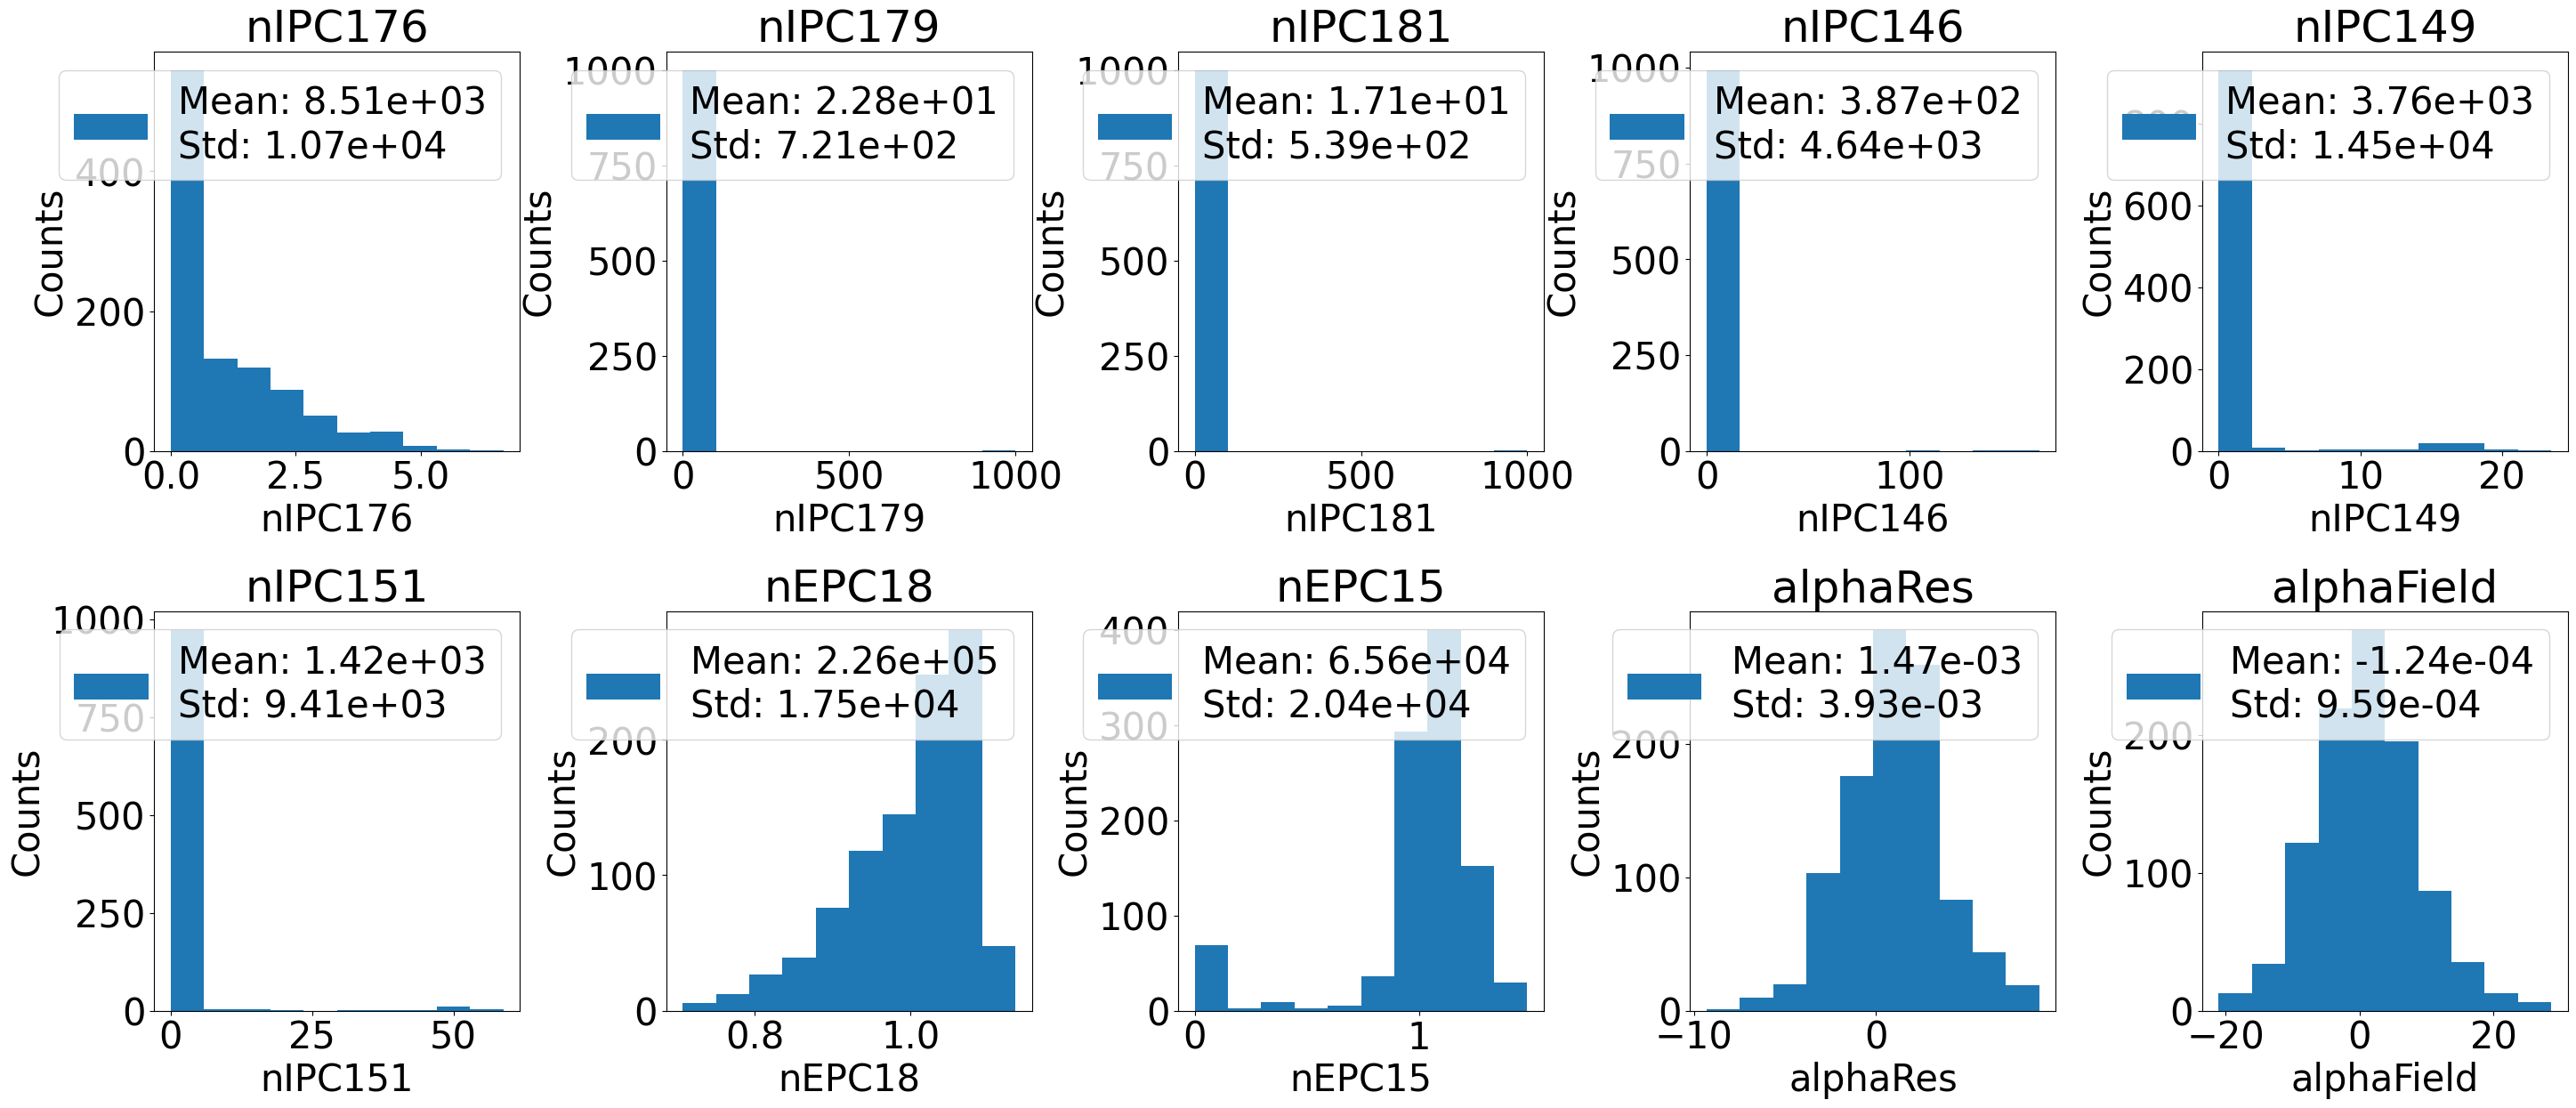

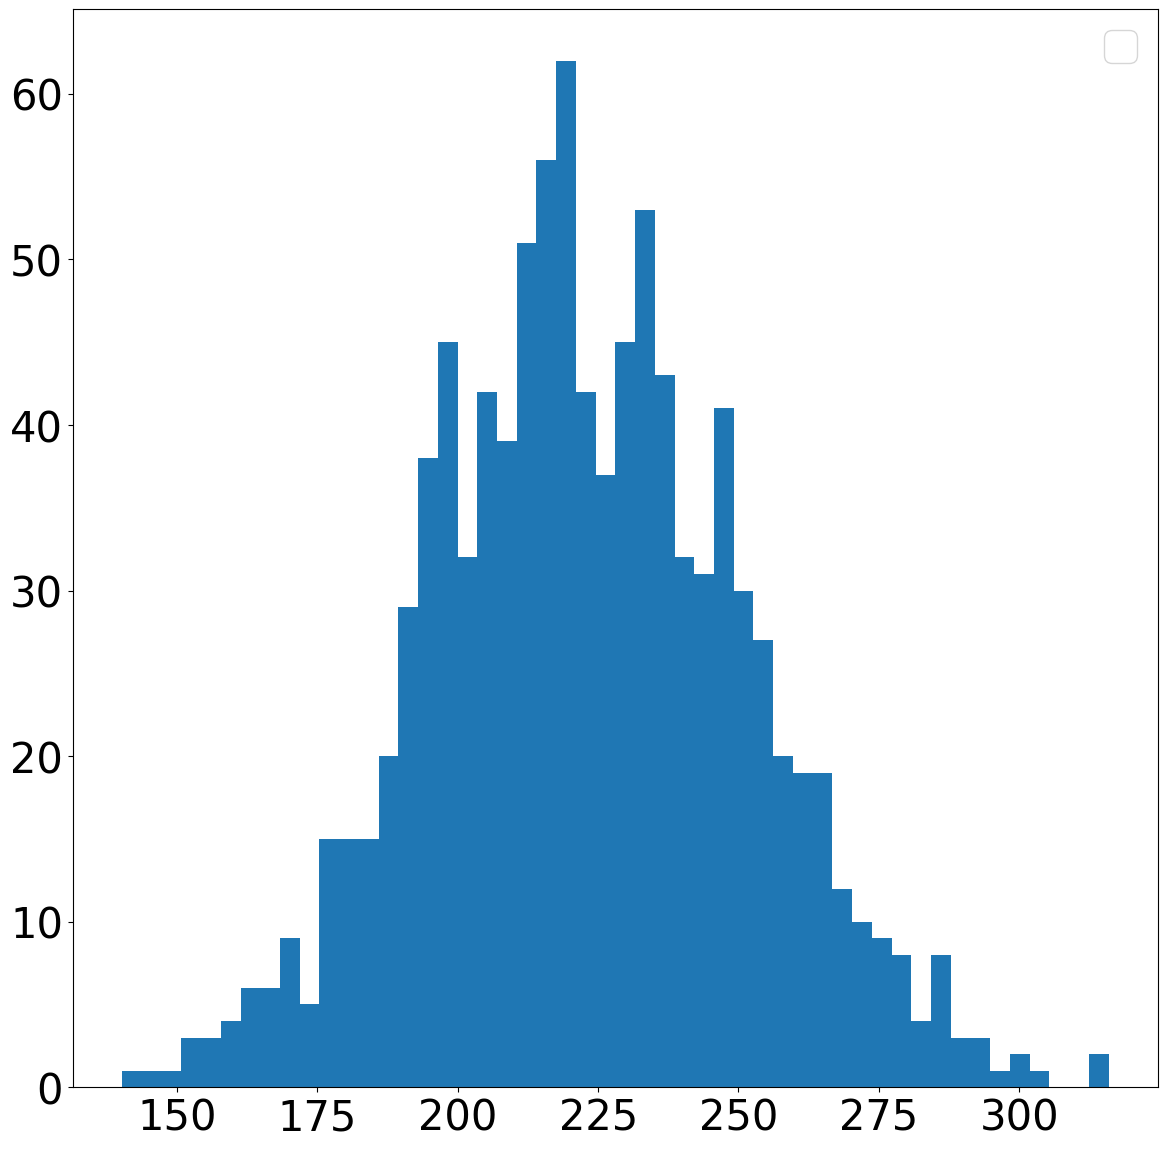

In [78]:
pars = [4.92065825e+04, 6.11433570e-10, 1.28383709e+04, 2.45125402e+04,
 1.09023901e-12, 1.74783144e+04, 1.46351241e+05, 5.46165101e+04]
morph = [0, 0]

PARS = []
Likelihood = []
Accurate = []
Valid = []
totPars = np.concatenate([pars, morph])
    
def llBKGOnlyWithMorphing(pars):
    nIPC176, nIPC179, nIPC181, nIPC146, nIPC149, nIPC151, nEPC18, nEPC15, alphaRes, alphaField = pars
    yields = np.array([nIPC176, nIPC179, nIPC181, nIPC146, nIPC149, nIPC151, nEPC18, nEPC15])
    mu0 = Hists.getEstimateToy(yields, morph = [alphaRes, alphaField])
    Vmu0 = Hists.getEstimateVarianceToy(yields)
    mueff = np.power(mu0, 2)/(Vmu0 + (mu0==0))
    betas = BBliteBeta(Hists.DataArrayToy, mu0, mueff)
    
    mu = Hists.getEstimateToy(yields, betas, morph = [alphaRes, alphaField])
    
    #print(pars, likelihood(Hists.DataArray, 0, mu, mueff, betas, 0) + np.power((alphaRes - alphares)/alphares, 2) + np.power((alphaField - 0)/alphafield, 2))
    return likelihood(Hists.DataArrayToy, 0, mu, mueff, betas, 0) + np.power((alphaRes - alphares)/alphares, 2) + np.power((alphaField - 0)/alphafield, 2)

for i in range(1000):
    np.random.seed(i)
    tpars = np.random.multivariate_normal(totPars, covariance)

    logL = Minuit(llBKGOnlyWithMorphing, tpars, name=['nIPC176', 'nIPC179', 'nIPC181', 'nIPC146', 'nIPC149', 'nIPC151', 'nEPC18', 'nEPC15', 'alphaRes', 'alphaField'])
    #print(tpars)
    tmorph = tpars[-2:]
    tpars = tpars[:-2]
    Hists.generateToy(tpars, betas = betas, fluctuateTemplates = True, morph = tmorph)

    for i in range(8):
        logL.limits[i] = (0, None)
    logL.limits[-2] = (alphavalues[0][0], alphavalues[0][-1])
    logL.limits[-1] = (alphavalues[1][0], alphavalues[1][-1])
    logL.simplex(ncall=100000)
    logL.strategy = 2
    logL.tol = 1e-10
    logL.migrad(ncall=100000, iterate=5)
    
    if (not logL.valid):
        I = 0
        while(not logL.valid):
            logL.simplex(ncall=100000)
            #for j in range(5):
            #    logL.scan(ncall=1e4)
            logL.strategy = 2
            logL.tol = 1e-10
            logL.migrad(ncall=100000, iterate=5)
            I += 1
            if I == 10:
                break
    logL.hesse()
    PARS.append(np.array(logL.values))
    Likelihood.append(logL.fval)
    Accurate.append(logL.accurate)
    Valid.append(logL.valid)

PARS = np.array(PARS)
Likelihood = np.array(Likelihood)
Valid = np.array(Valid)
Accurate = np.array(Accurate)

print(np.mean(Likelihood[Valid == True]))
print(Valid[Likelihood > 2000])
print(Likelihood[Likelihood > 2000])
print(np.where(Likelihood > 2000))
print(len(Likelihood[Likelihood < 10000]))
print(len(Likelihood))
print(len(Valid[Valid==False]), len(Accurate[Accurate==False]))
print(Valid, Accurate)


fig = plt.figure(figsize=(35, 14), dpi=100)
plt.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(len(logL.parameters)):
    plt.subplot(2, 5, i+1)
    tpars = np.array([p[i] for p in PARS[Likelihood < 10000]])
    plt.hist(tpars/tpars.mean(), label= f'Mean: {tpars.mean():.2e}\nStd: {tpars.std():.2e}')
    plt.xlabel(logL.parameters[i])
    plt.ylabel('Counts')
    plt.legend()
    plt.title(logL.parameters[i])

fig = plt.figure(figsize=(14, 14), dpi=100)
plt.hist(Likelihood, bins=50)
plt.legend()
